In [1]:
import cv2 as cv
import pandas as pd
import numpy as np


def get_components(image):
    """Get the individual connected components of an image

    Returns:
        tuple (labeled_image, coordinates, components)
    """

    processed = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    processed = cv.threshold(processed, 0, 1, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    _, img, stats, _ = cv.connectedComponentsWithStats(processed)
    coords = pd.DataFrame(
        stats[
            :,
            [
                cv.CC_STAT_LEFT,
                cv.CC_STAT_TOP,
                cv.CC_STAT_WIDTH,
                cv.CC_STAT_HEIGHT,
            ],
        ],
        columns=["x", "y", "w", "h"],
    )
    coords["x2"] = coords.x + coords.w
    coords["y2"] = coords.y + coords.h

    return (
        img,
        coords,
        [processed[r.y : r.y2, r.x : r.x2] for _, r in coords.iterrows()],
    )

In [2]:
get_components(cv.imread("twinkle2.jpg"))

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
        x     y     w     h    x2    y2
 0      0     0  1000  1414  1000  1414
 1    436    85     6    30   442   115
 2    460    86    29    27   489   113
 3    494    86    29    28   523   114
 4    447    93     9    14   456   107
 ..   ...   ...   ...   ...   ...   ...
 148  669  1226     9    16   678  1242
 149  751  1226    10    16   761  1242
 150  822  1226     9    16   831  1242
 151  356  1232    15     4   371  1236
 152  471  1399     4    14   475  1413
 
 [153 rows x 6 columns],
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, 1, 1, 1],
     

In [3]:
def generate_components(write: bool = False):
    from pathlib import Path

    Path("components/").mkdir(exist_ok=True)

    filtered = []

    i = 0
    for img in Path("scores/").iterdir():
        components = get_components(cv.imread(str(img.resolve())))
        for component in components[2]:
            if component.shape[0] * component.shape[1] > 40_000:
                continue  # component too large

            filtered.append(component)

            if not write:
                continue

            cv.imwrite(str(Path("components") / f"{i}.jpg"), component * 255)
            i += 1
            if i % 50 == 0:
                print(i)

    return filtered

Text(0.5, 1.0, "Similarities from 'F'")

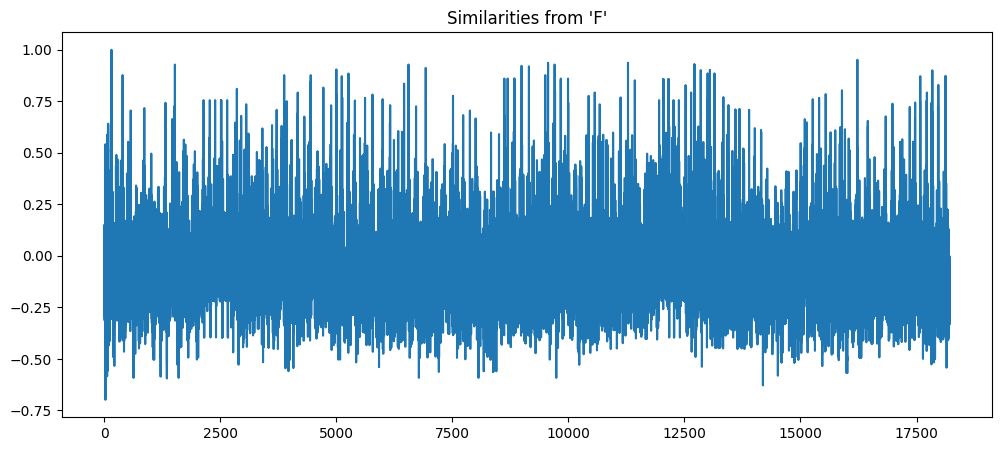

In [4]:
ref = cv.imread("categorized/156.jpg")  # "F" as in a chord
ref = cv.cvtColor(ref, cv.COLOR_BGR2GRAY)
ref = cv.threshold(ref, 0, 1, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

components = generate_components()
similarities = np.empty(len(components))
for i, component in enumerate(components):
    resized = cv.resize(
        component, (ref.shape[1], ref.shape[0]), interpolation=cv.INTER_NEAREST
    )
    similarity = cv.matchTemplate(resized, ref, cv.TM_CCOEFF_NORMED).item()

    similarities[i] = similarity

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(similarities)
plt.title("Similarities from 'F'")

/tmp/ipykernel_42368/1623136898.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(6, 6, figsize=(12, 12))


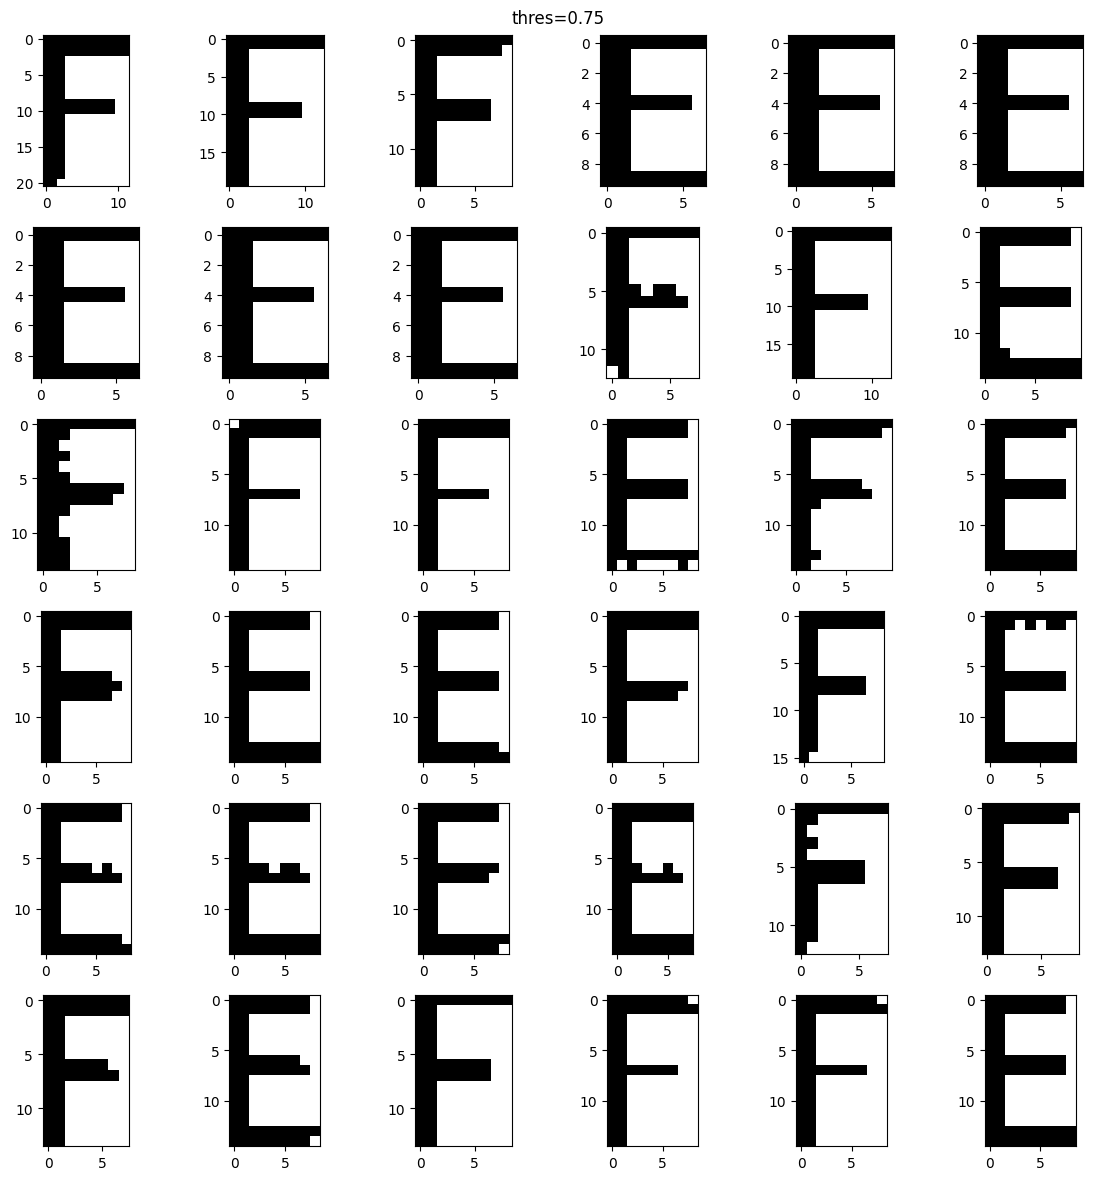

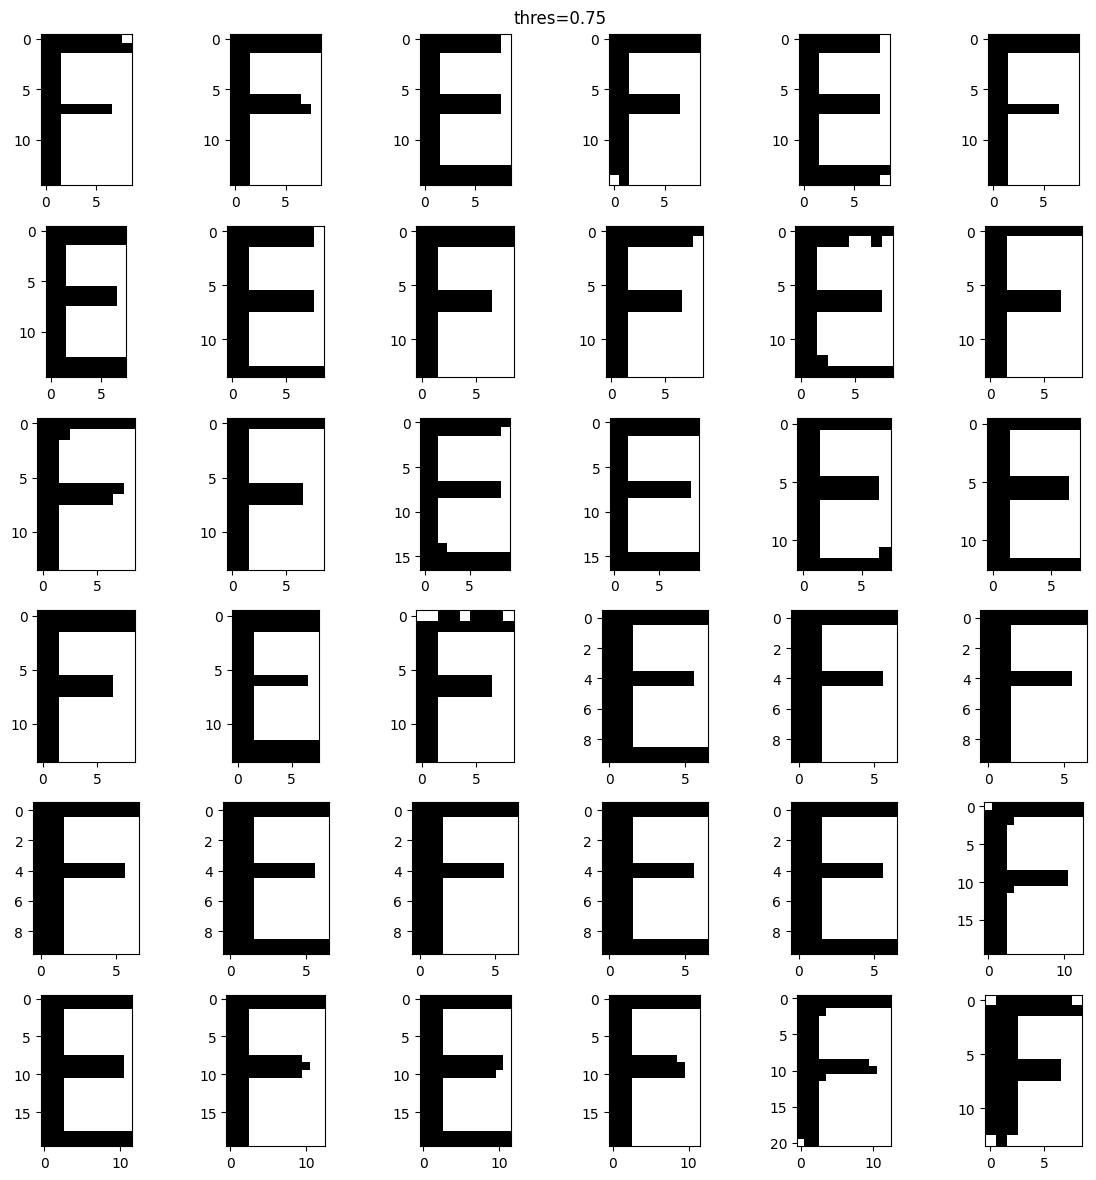

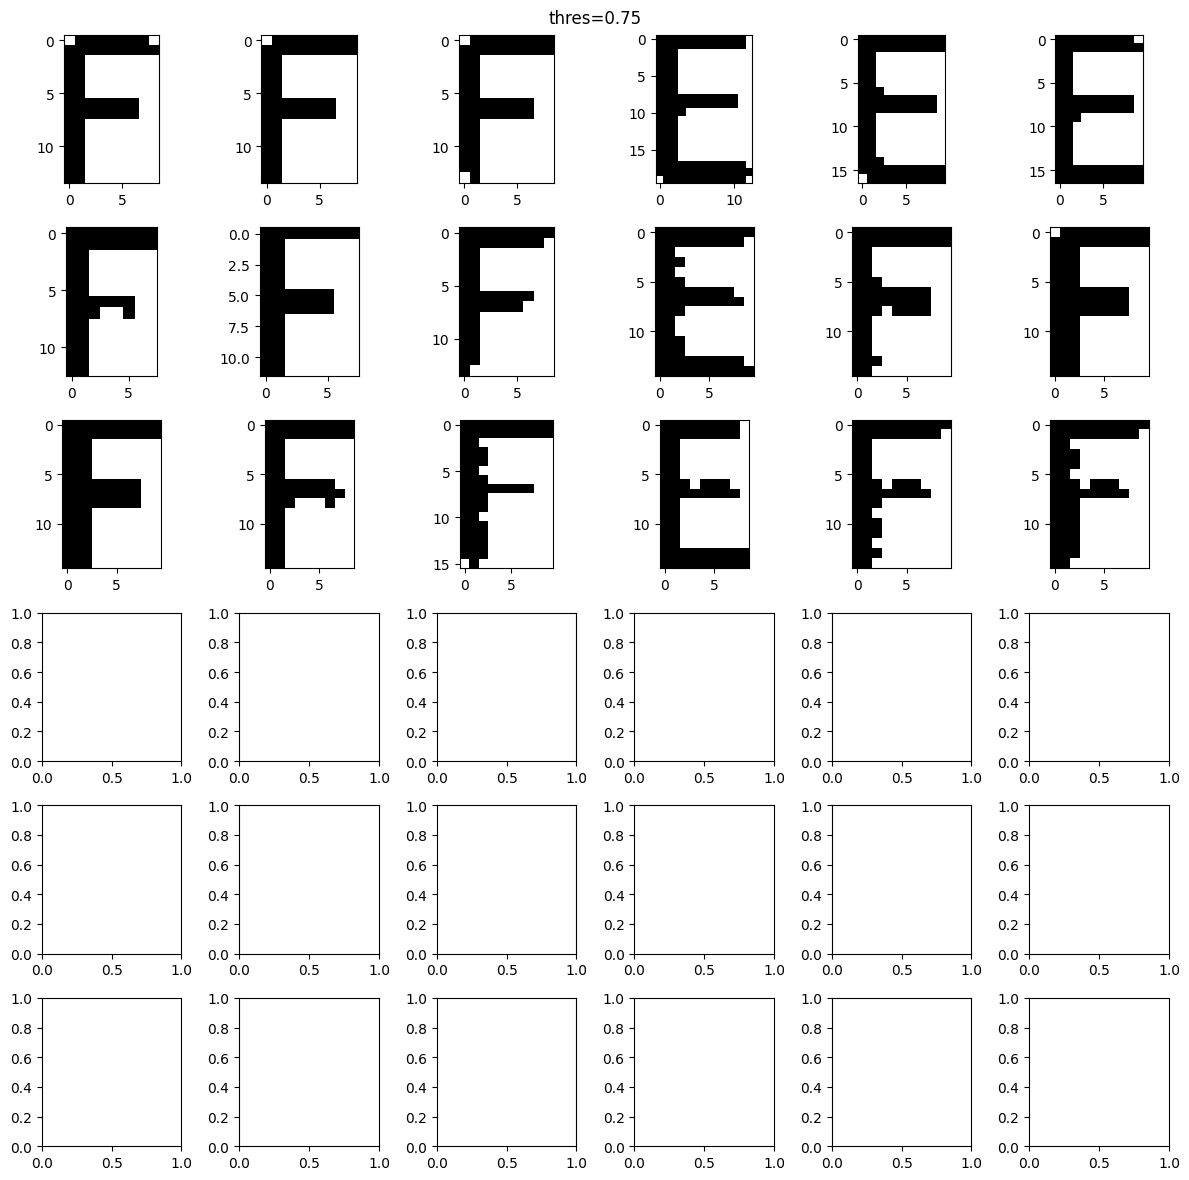

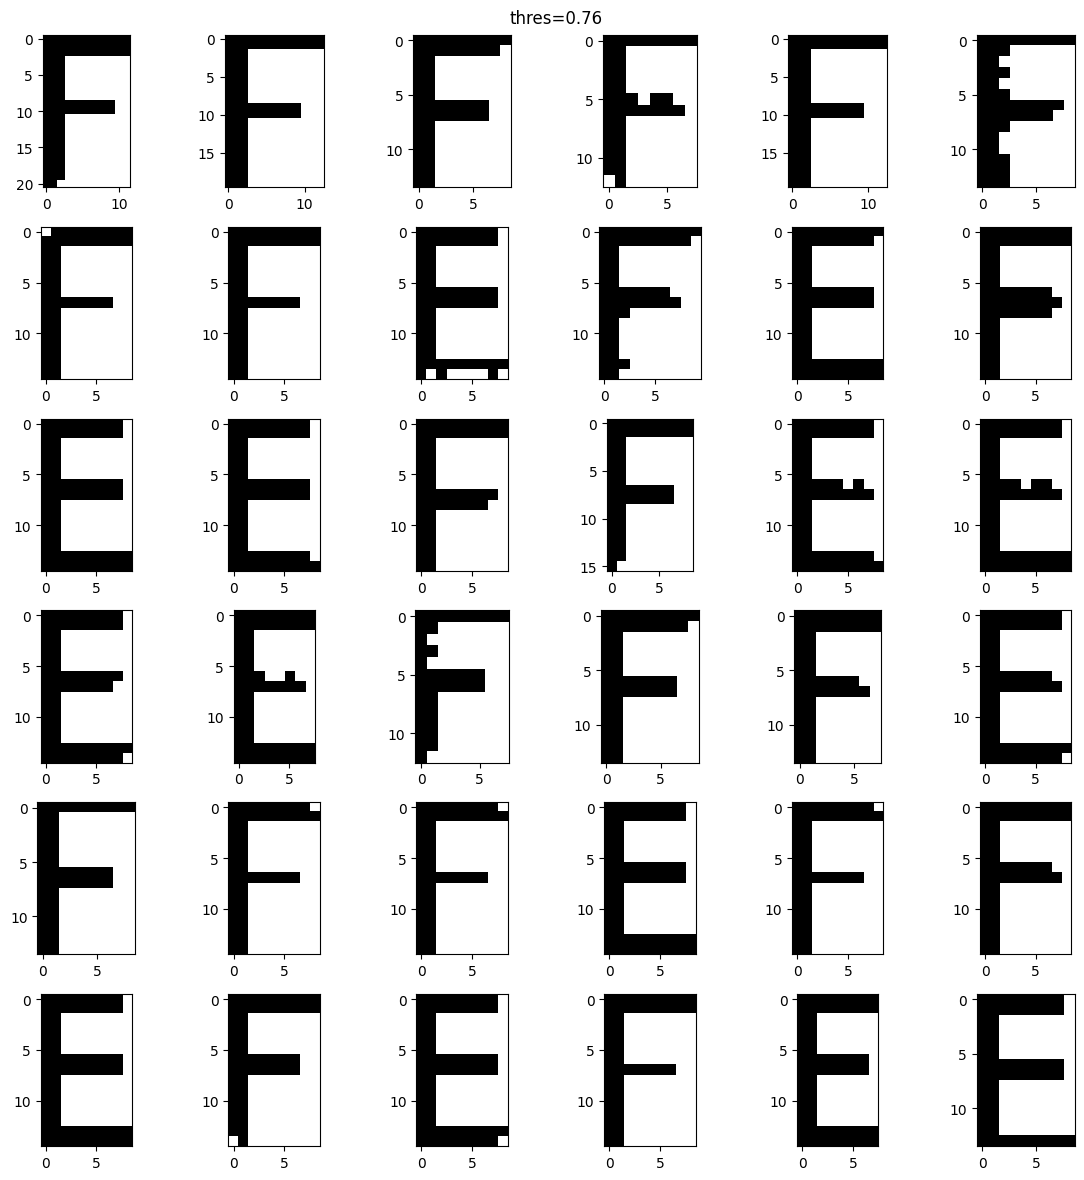

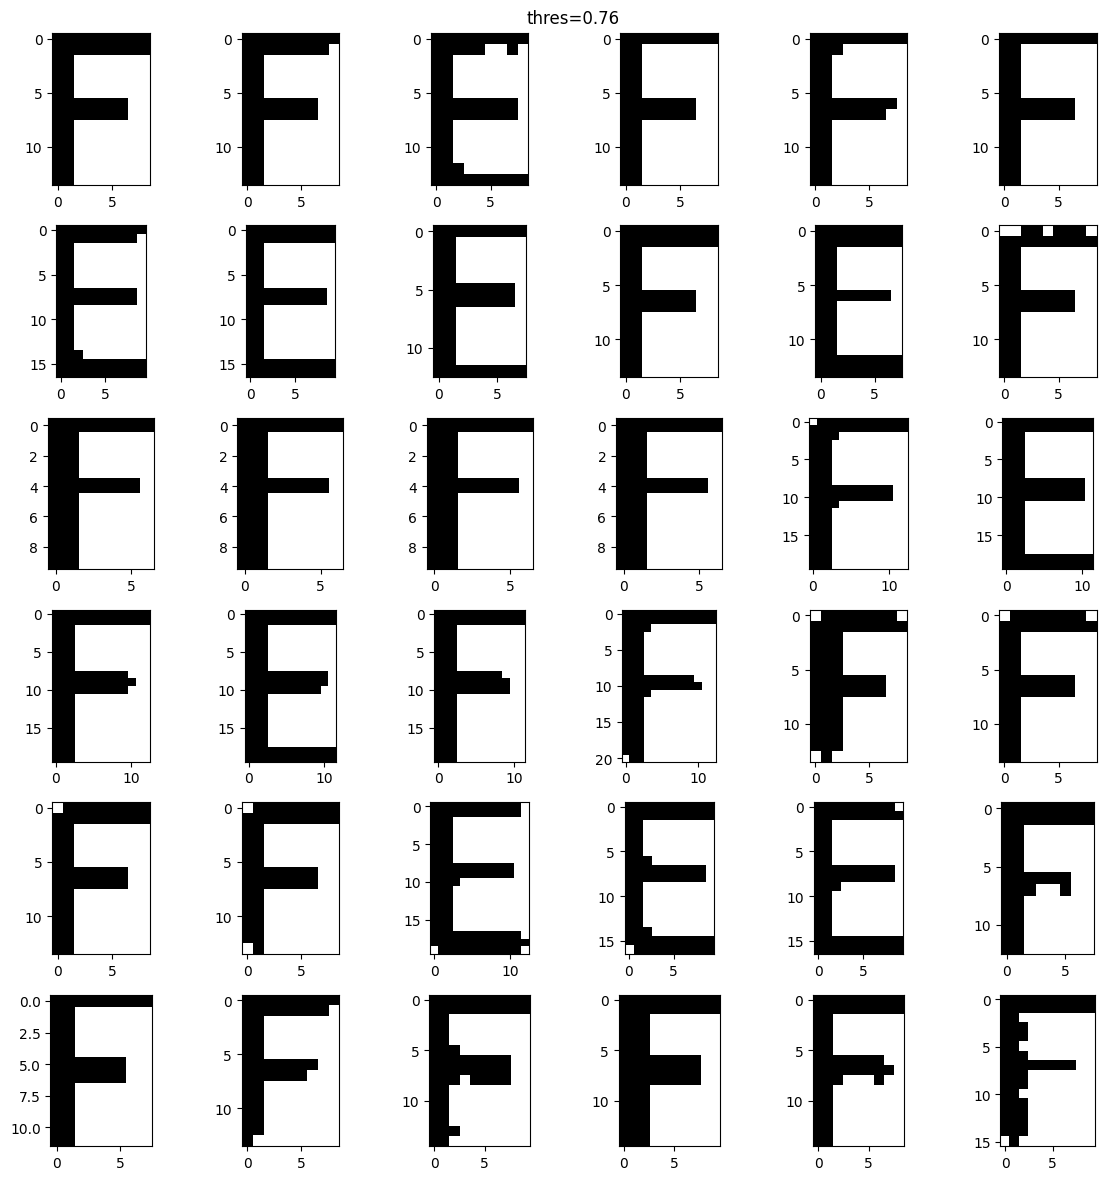

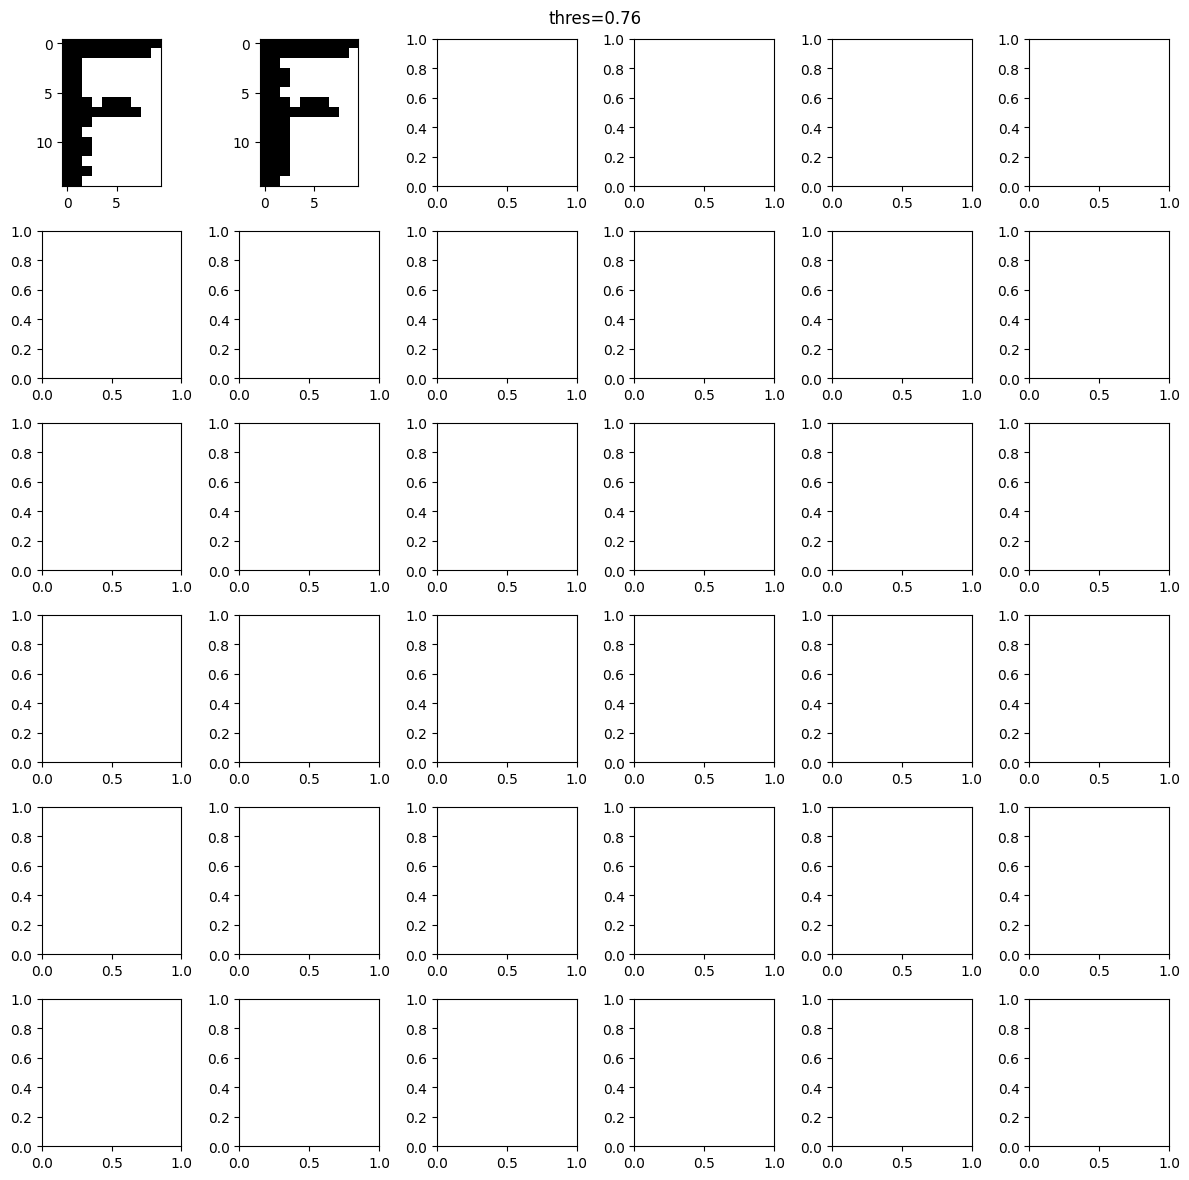

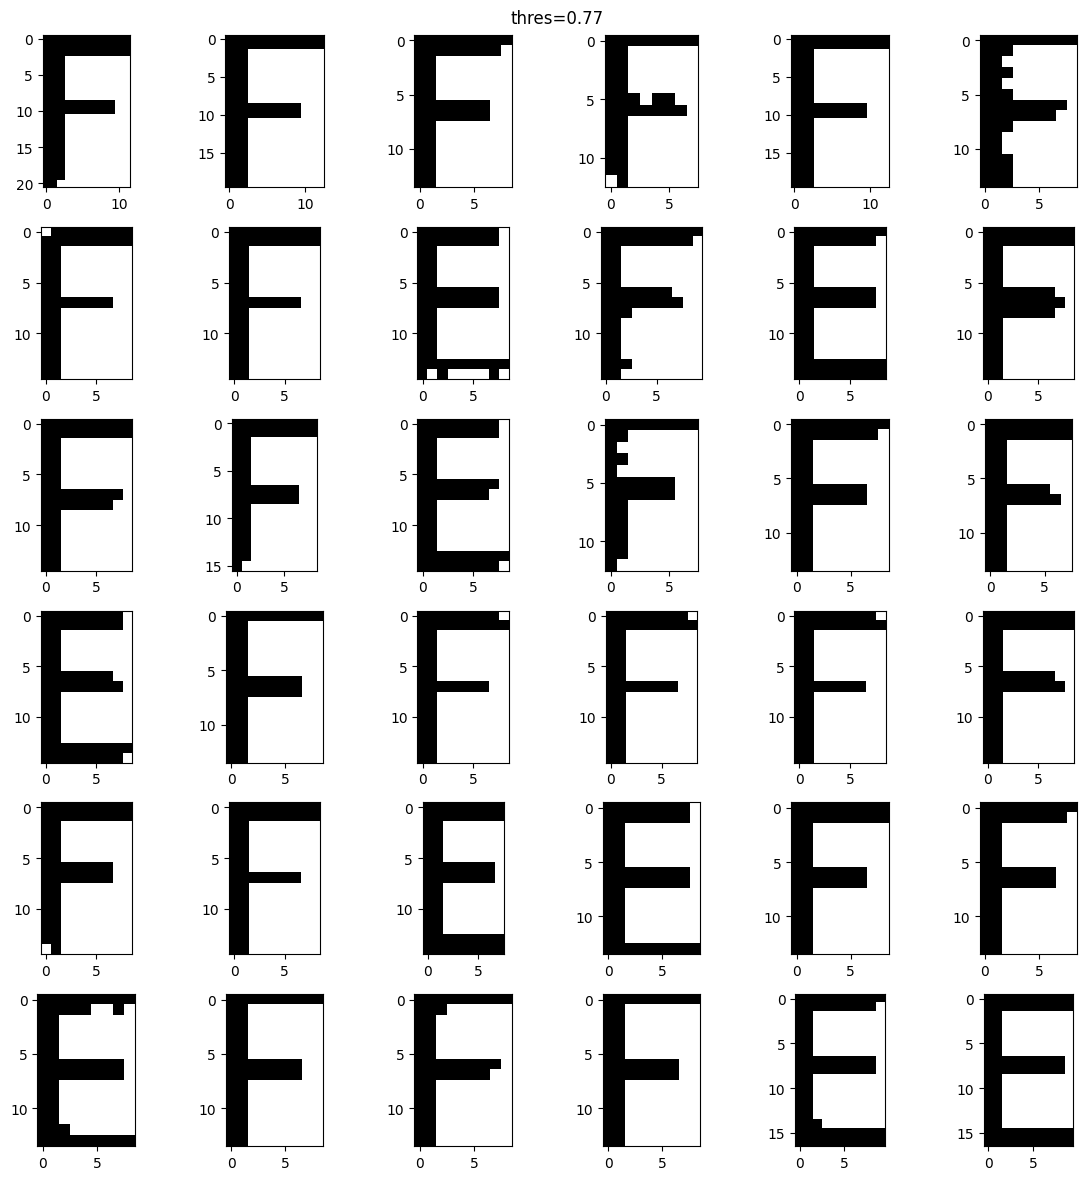

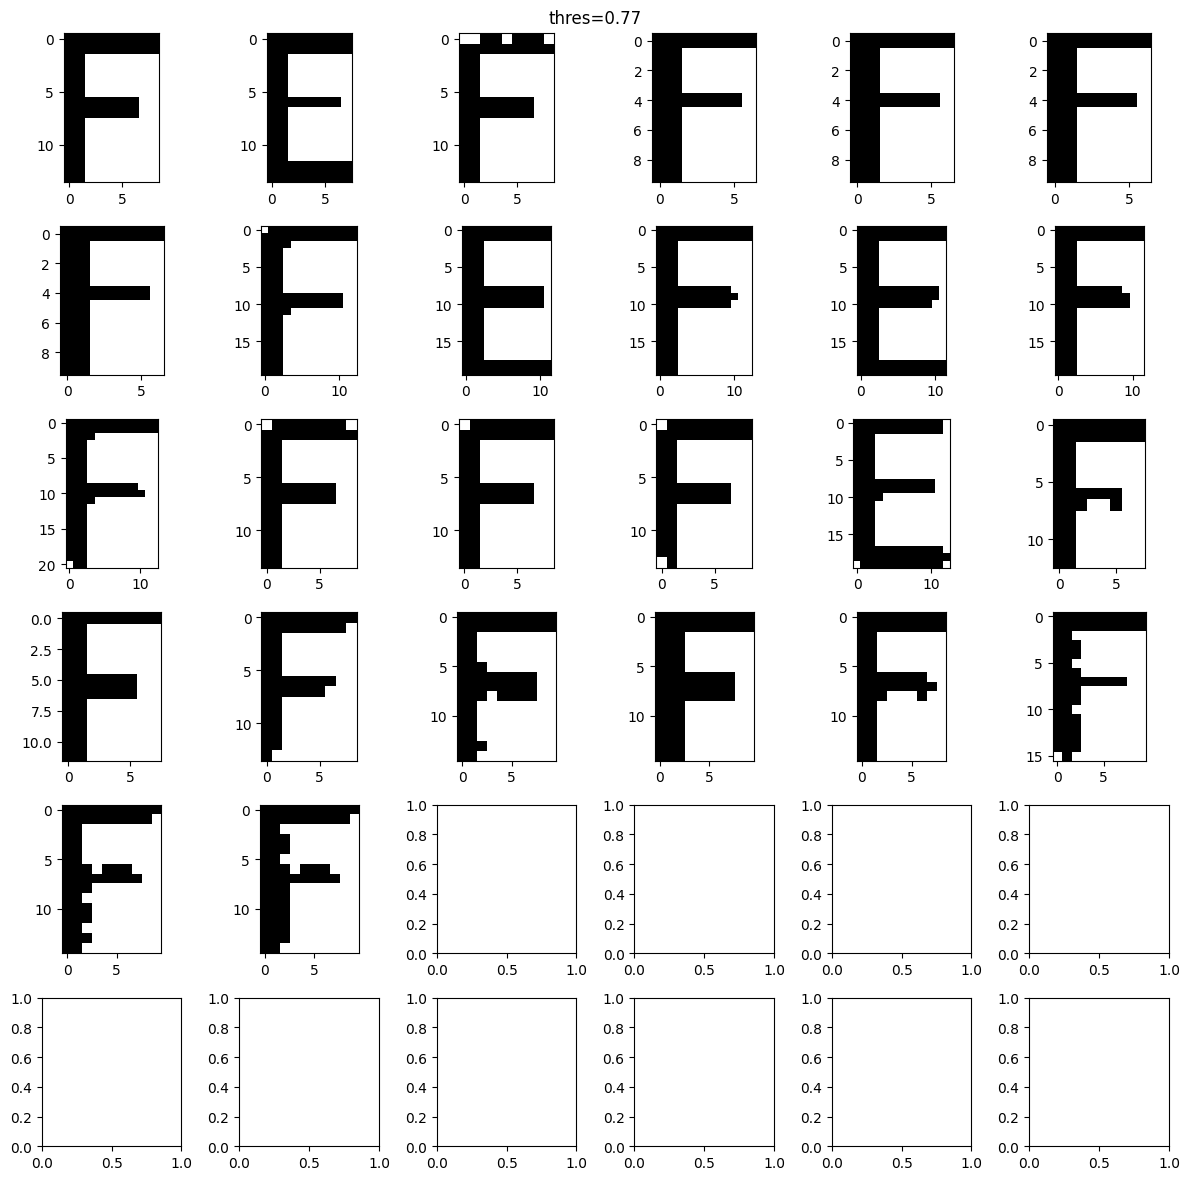

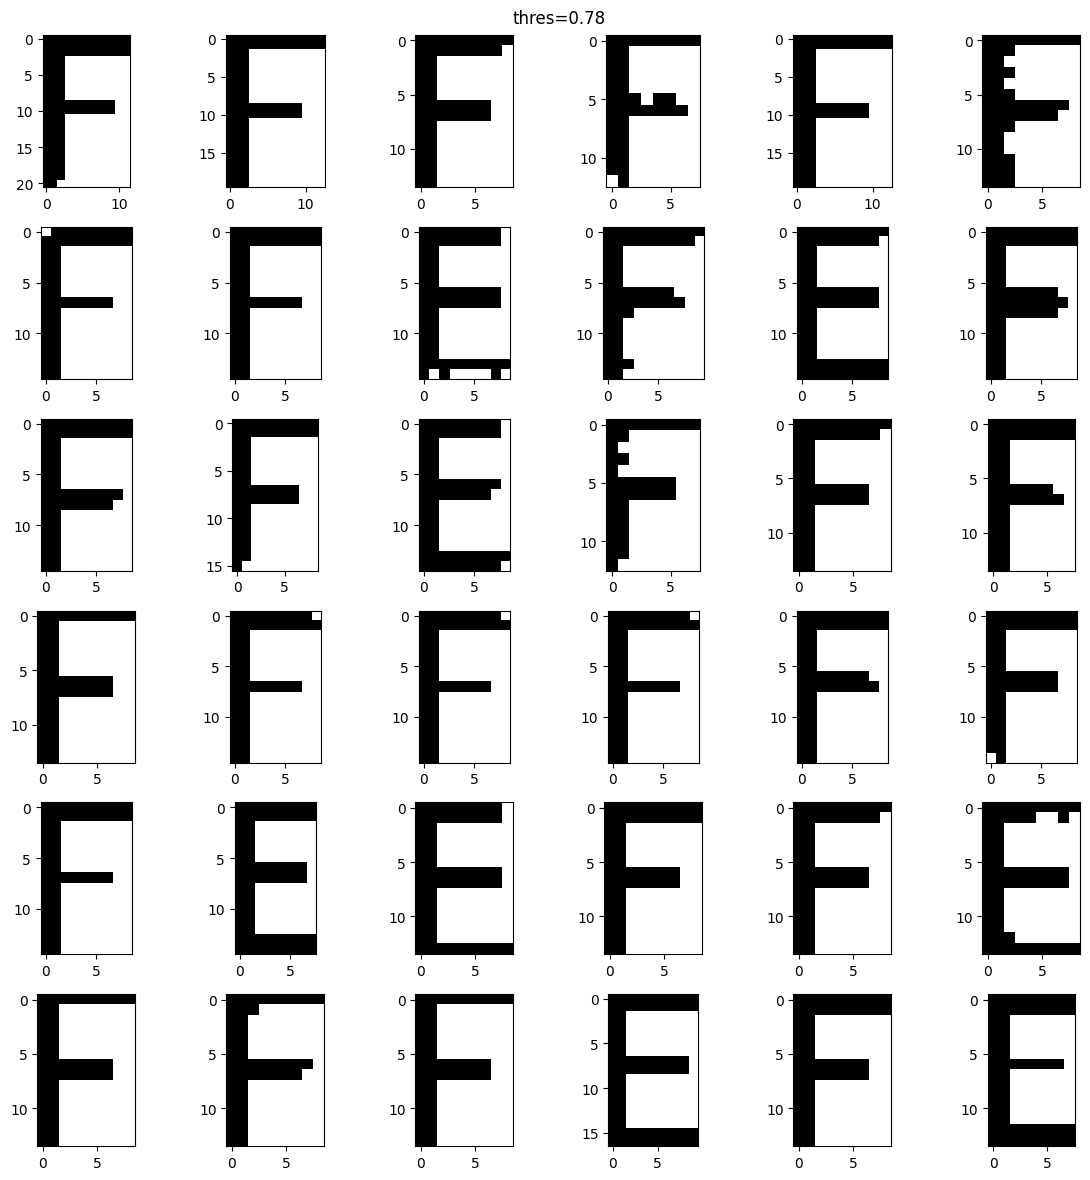

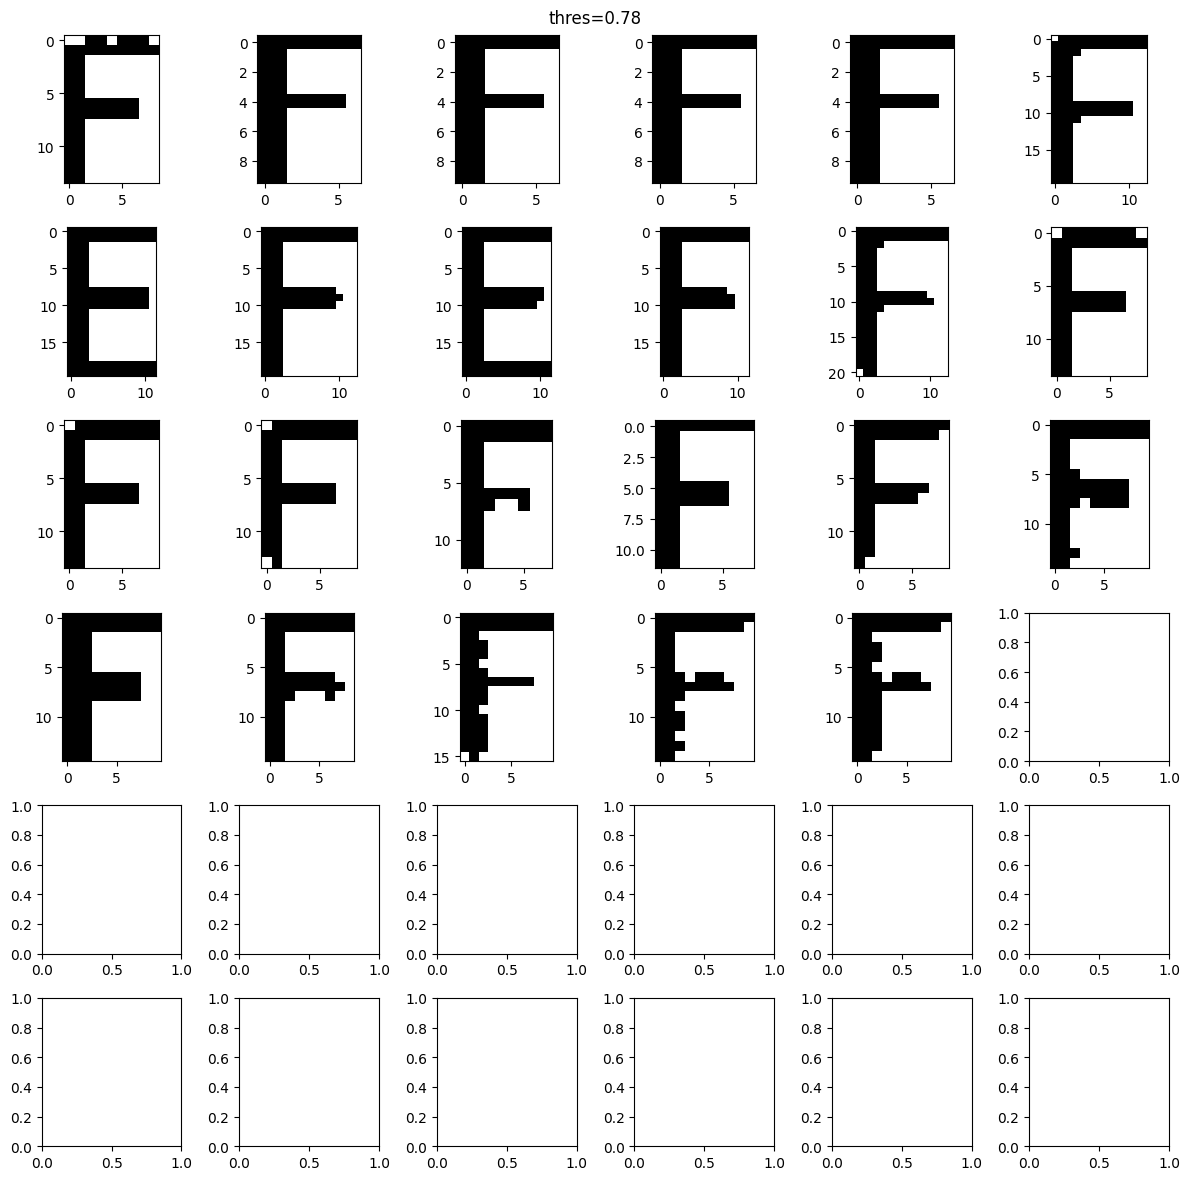

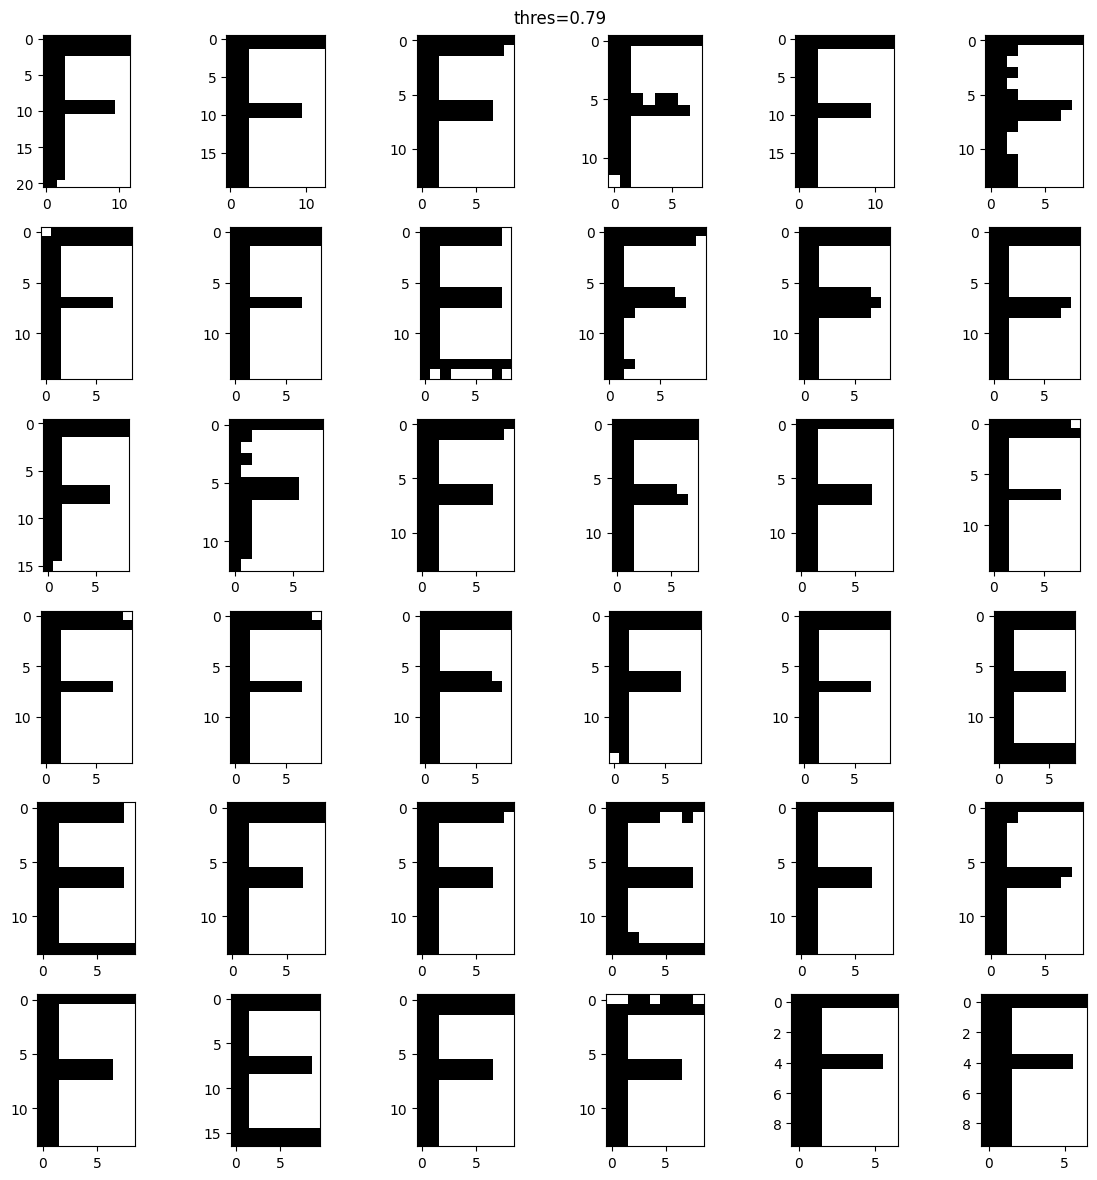

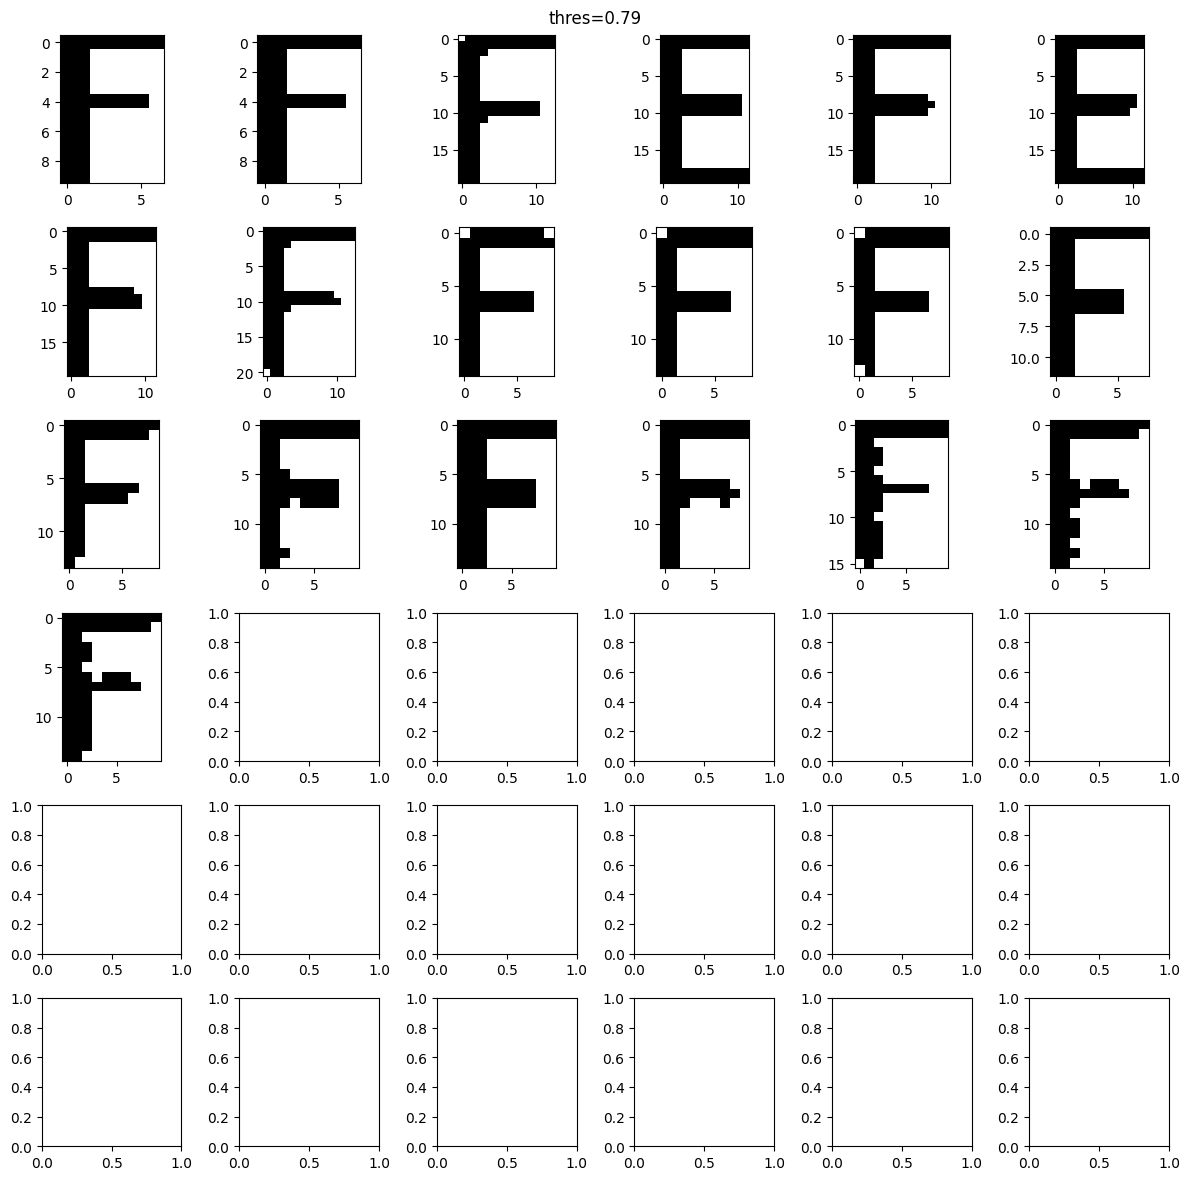

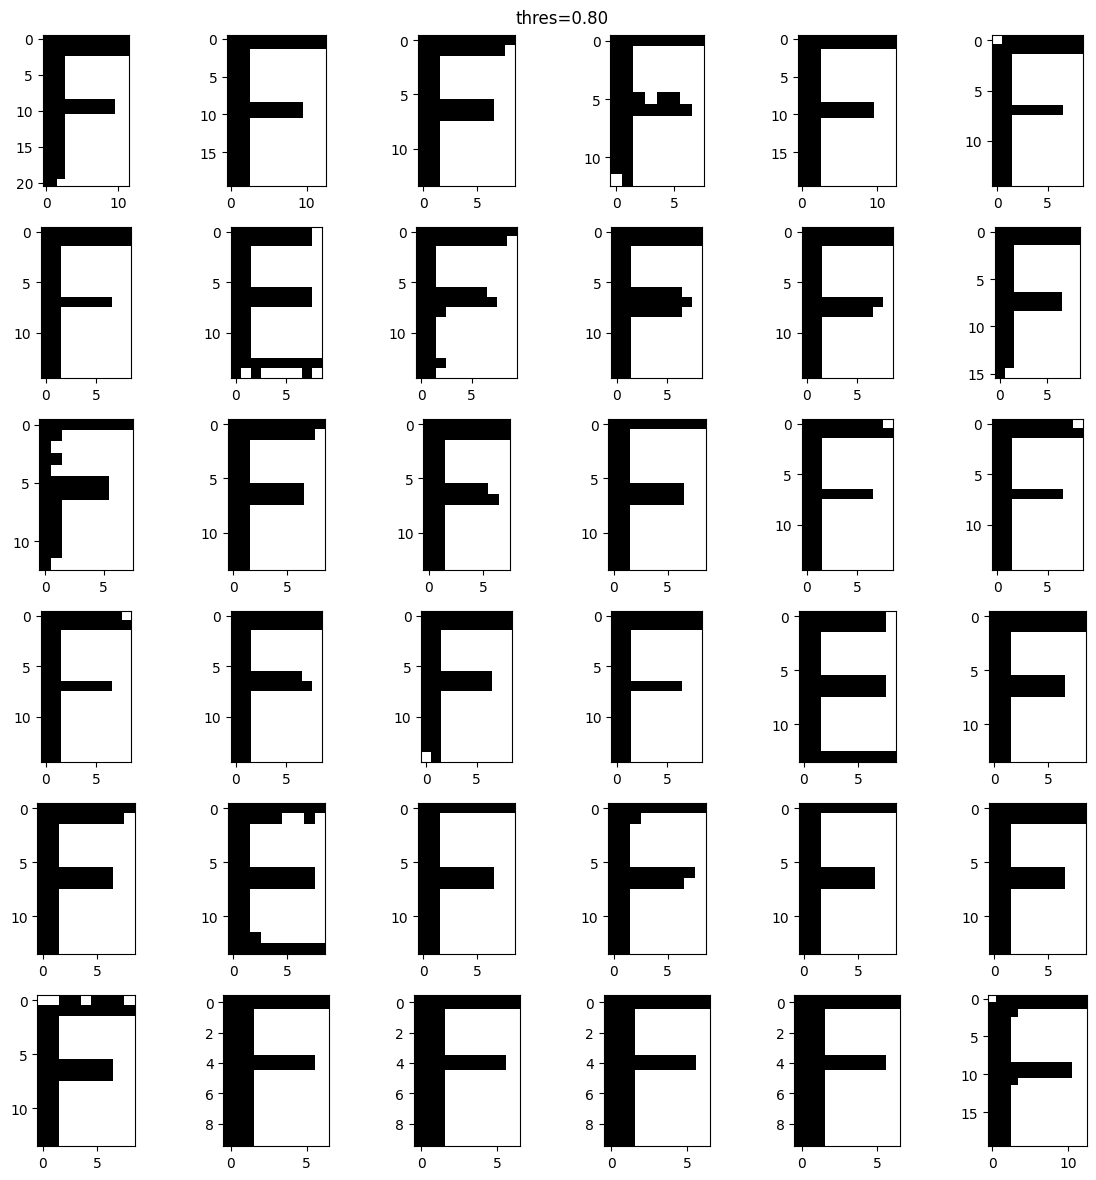

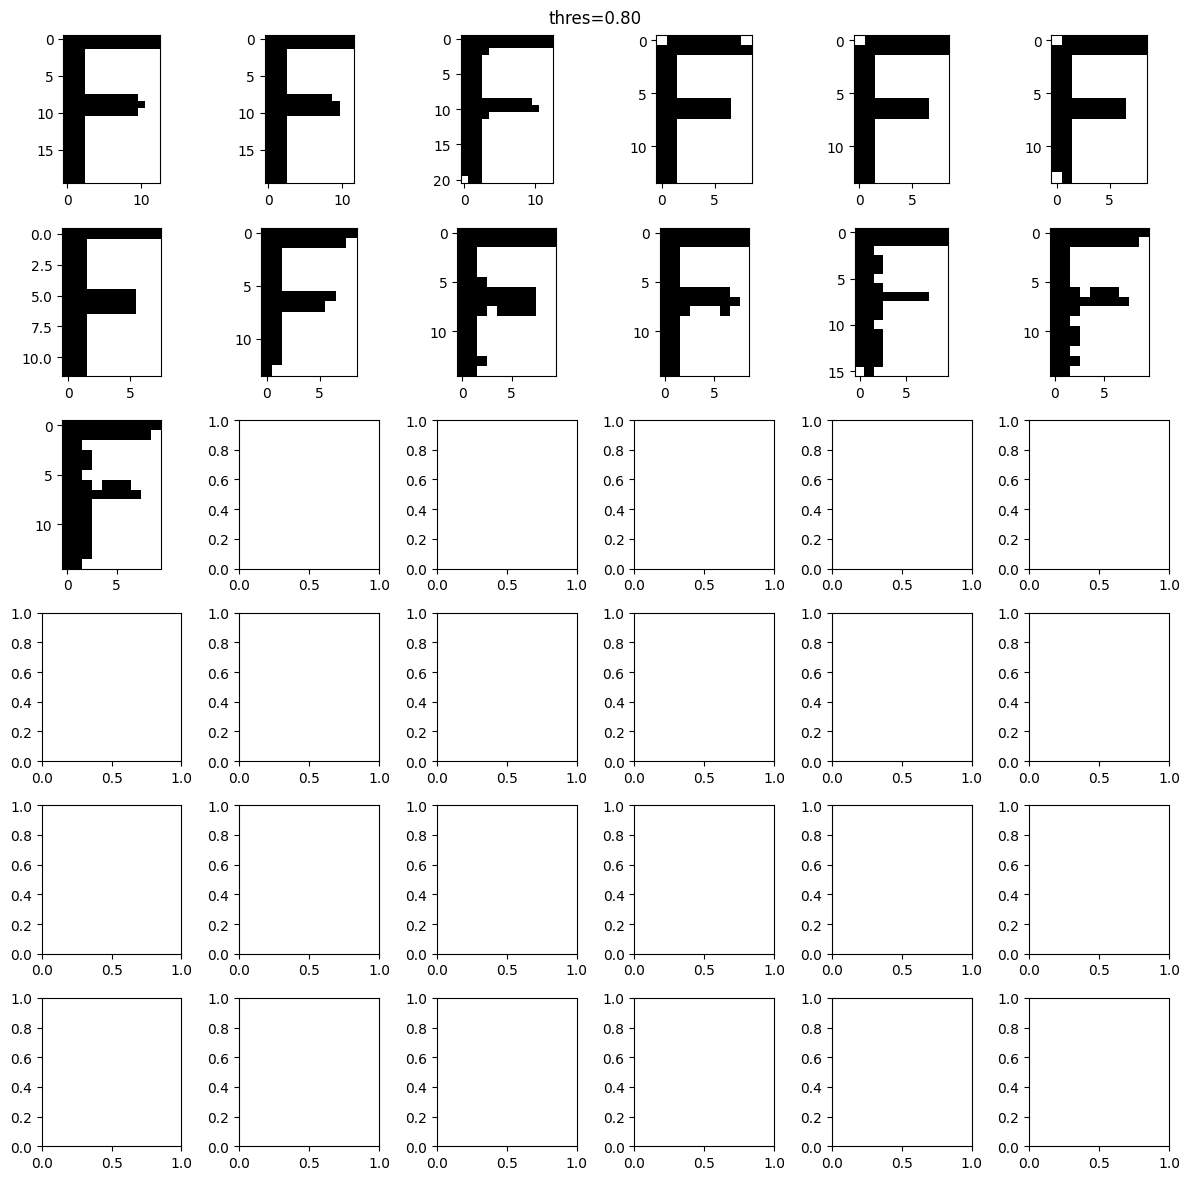

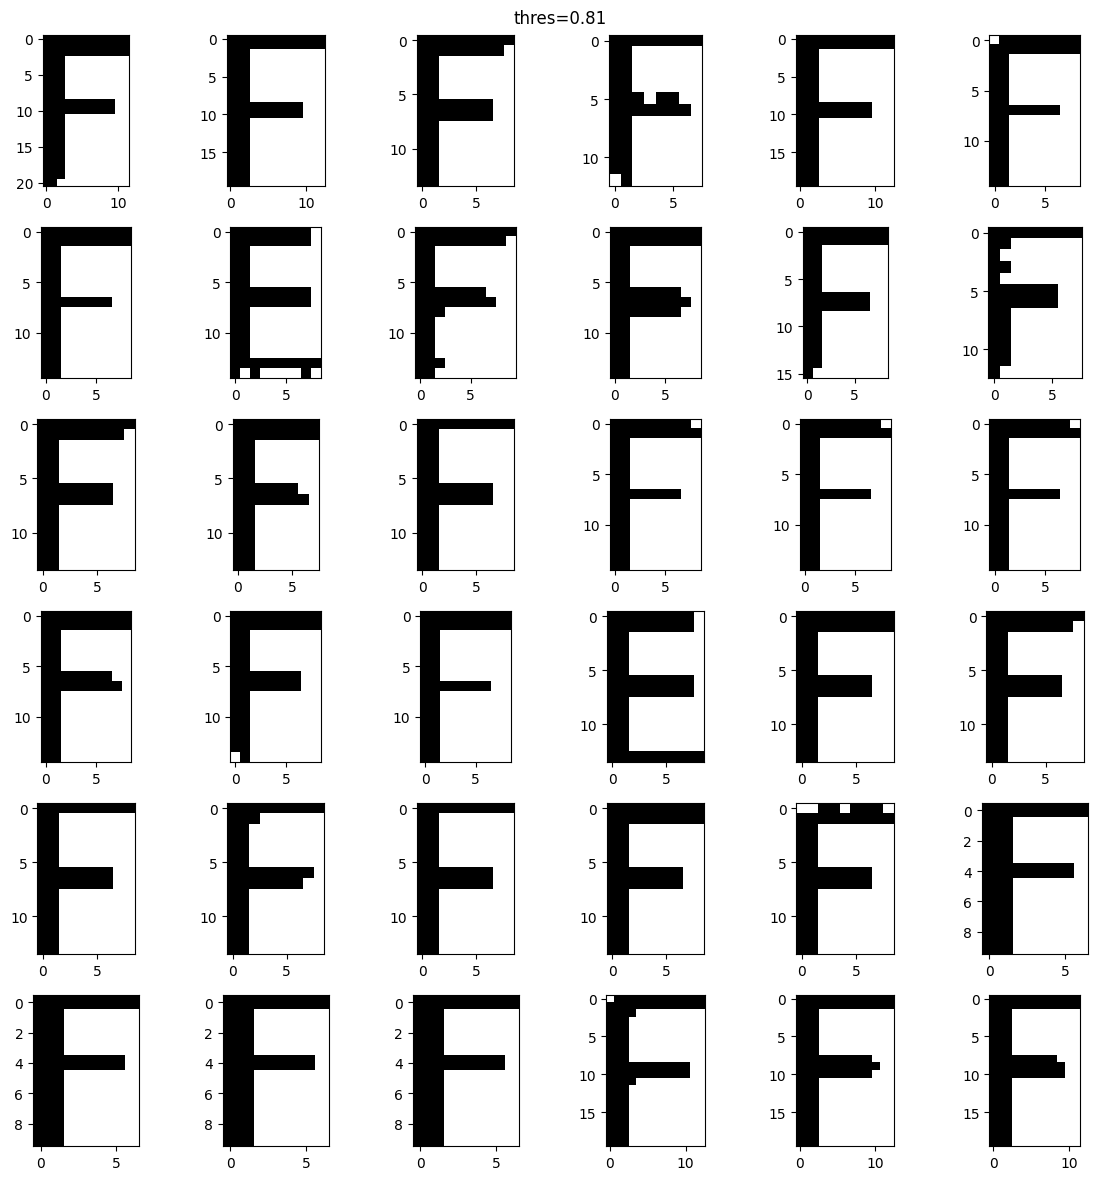

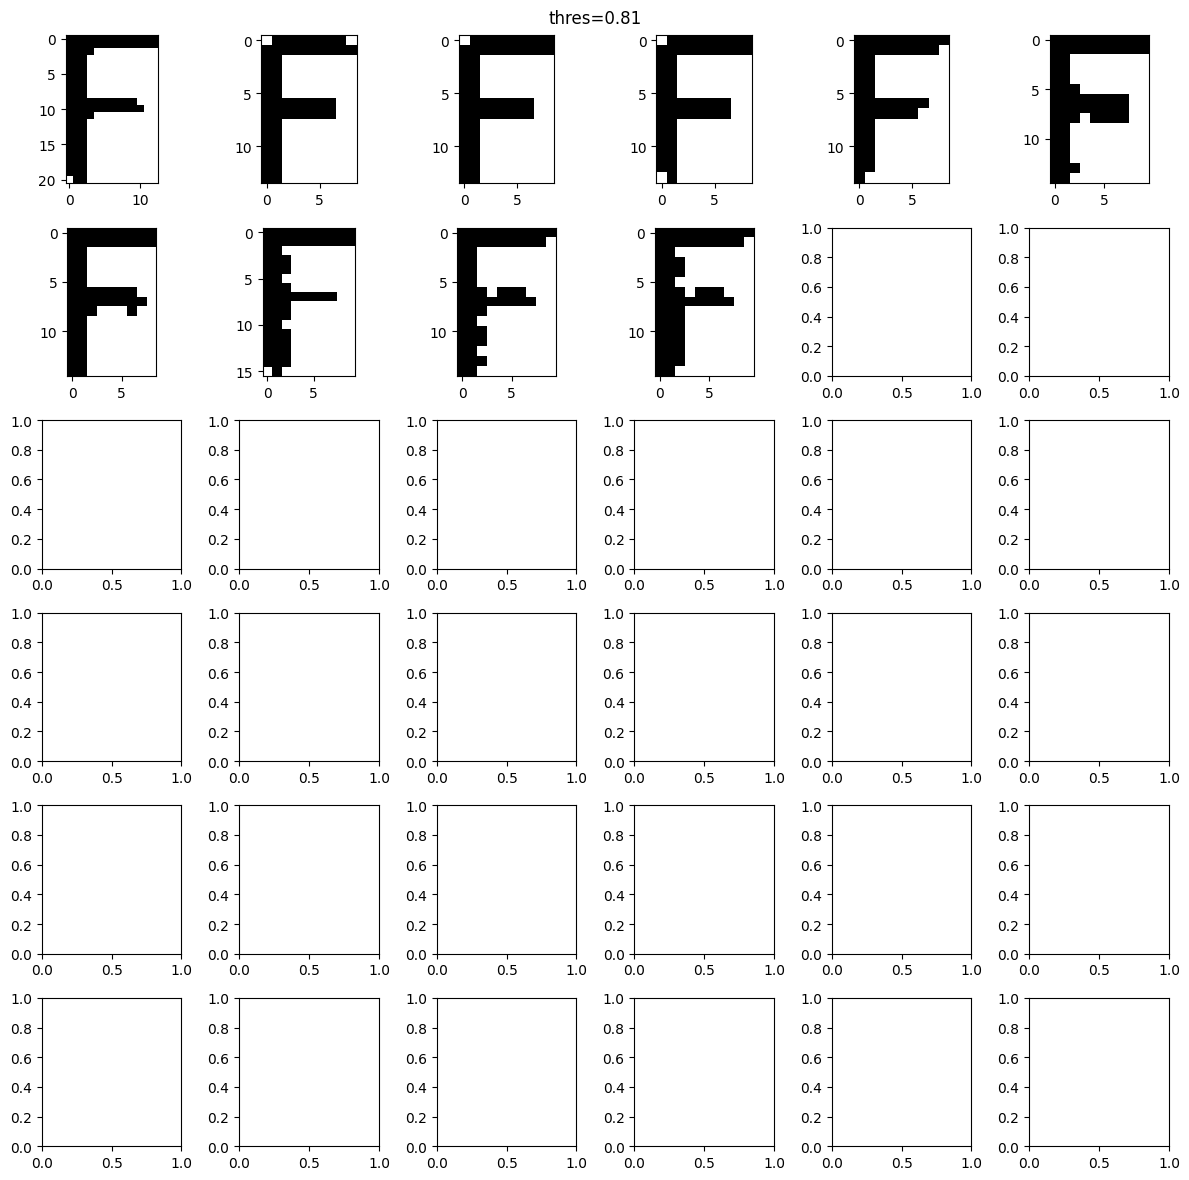

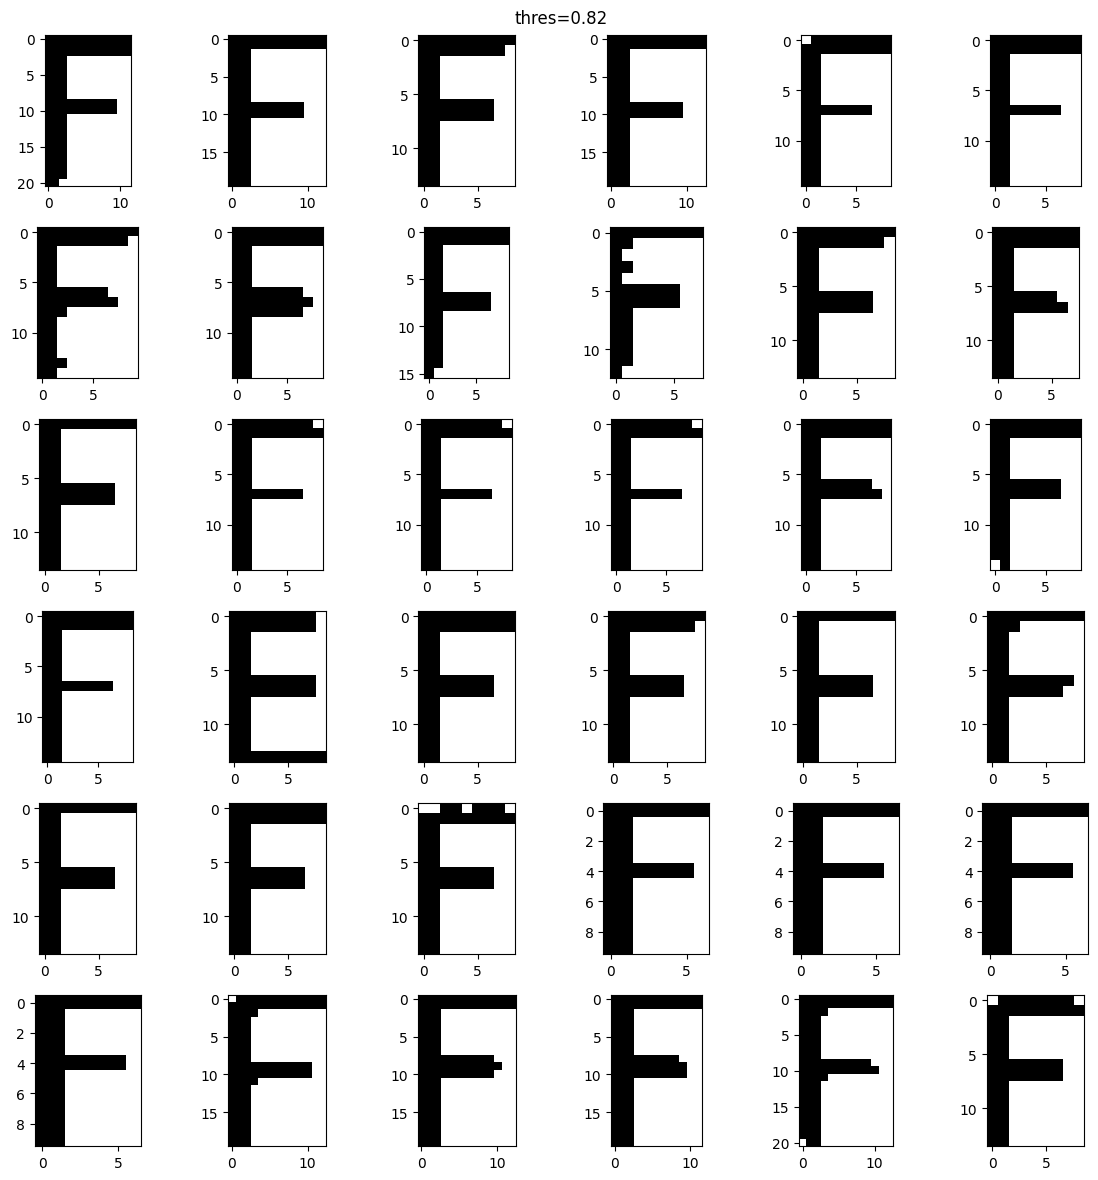

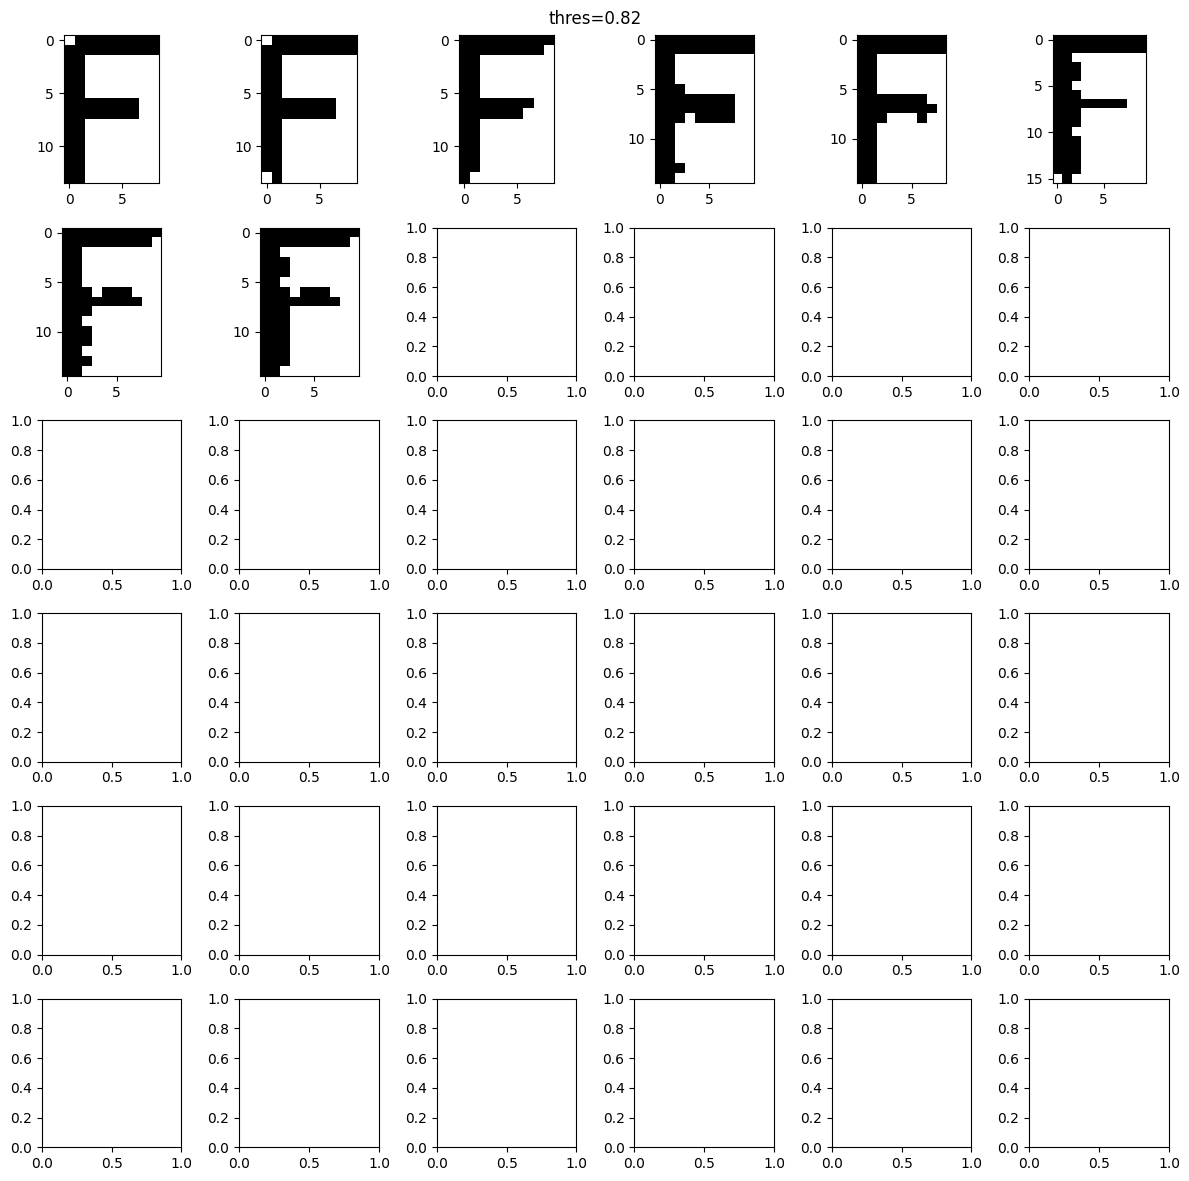

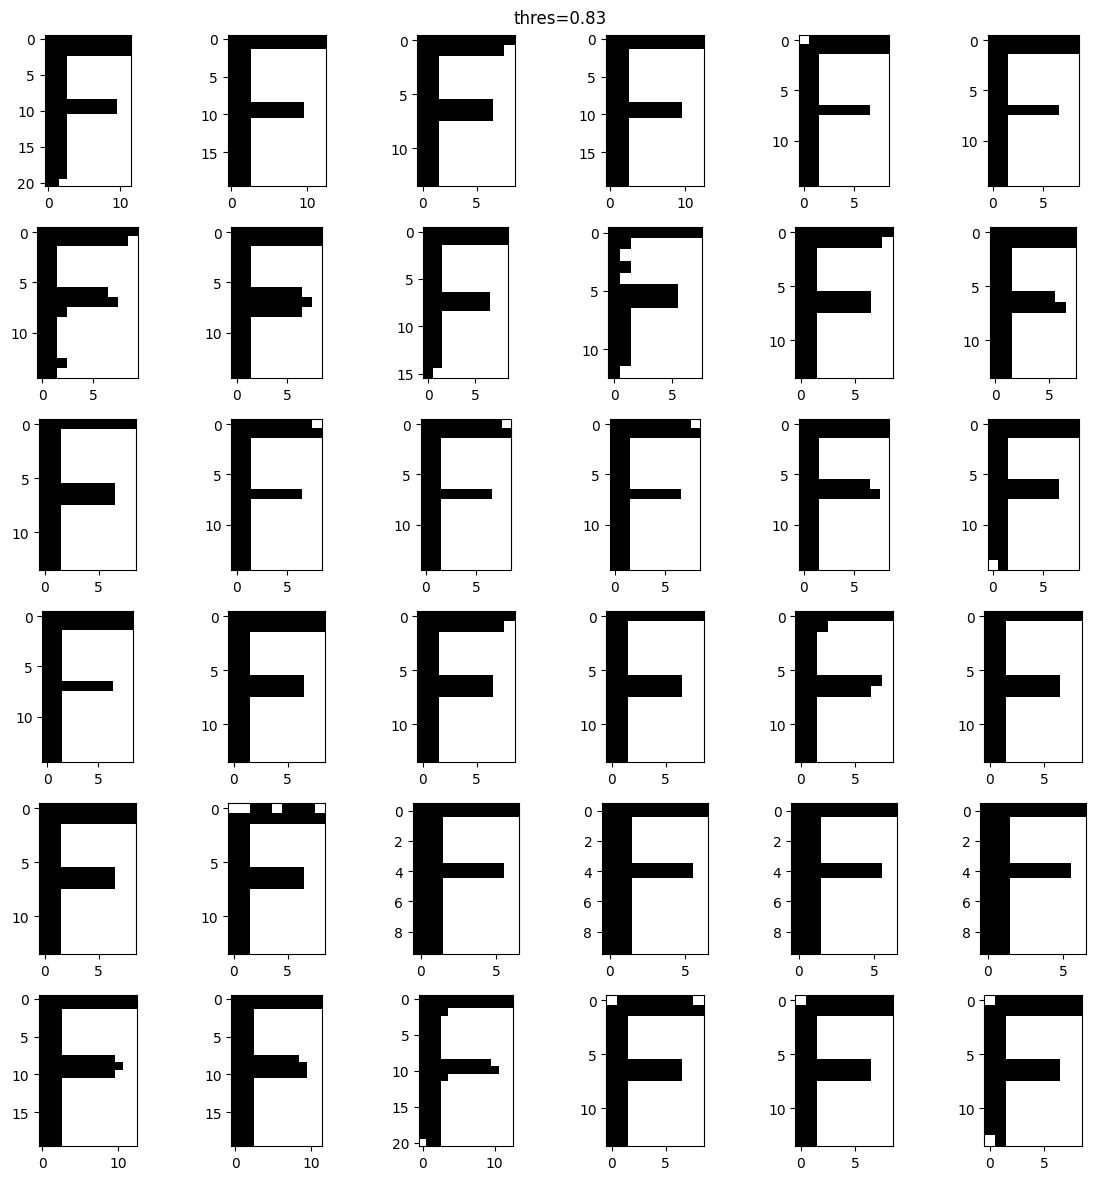

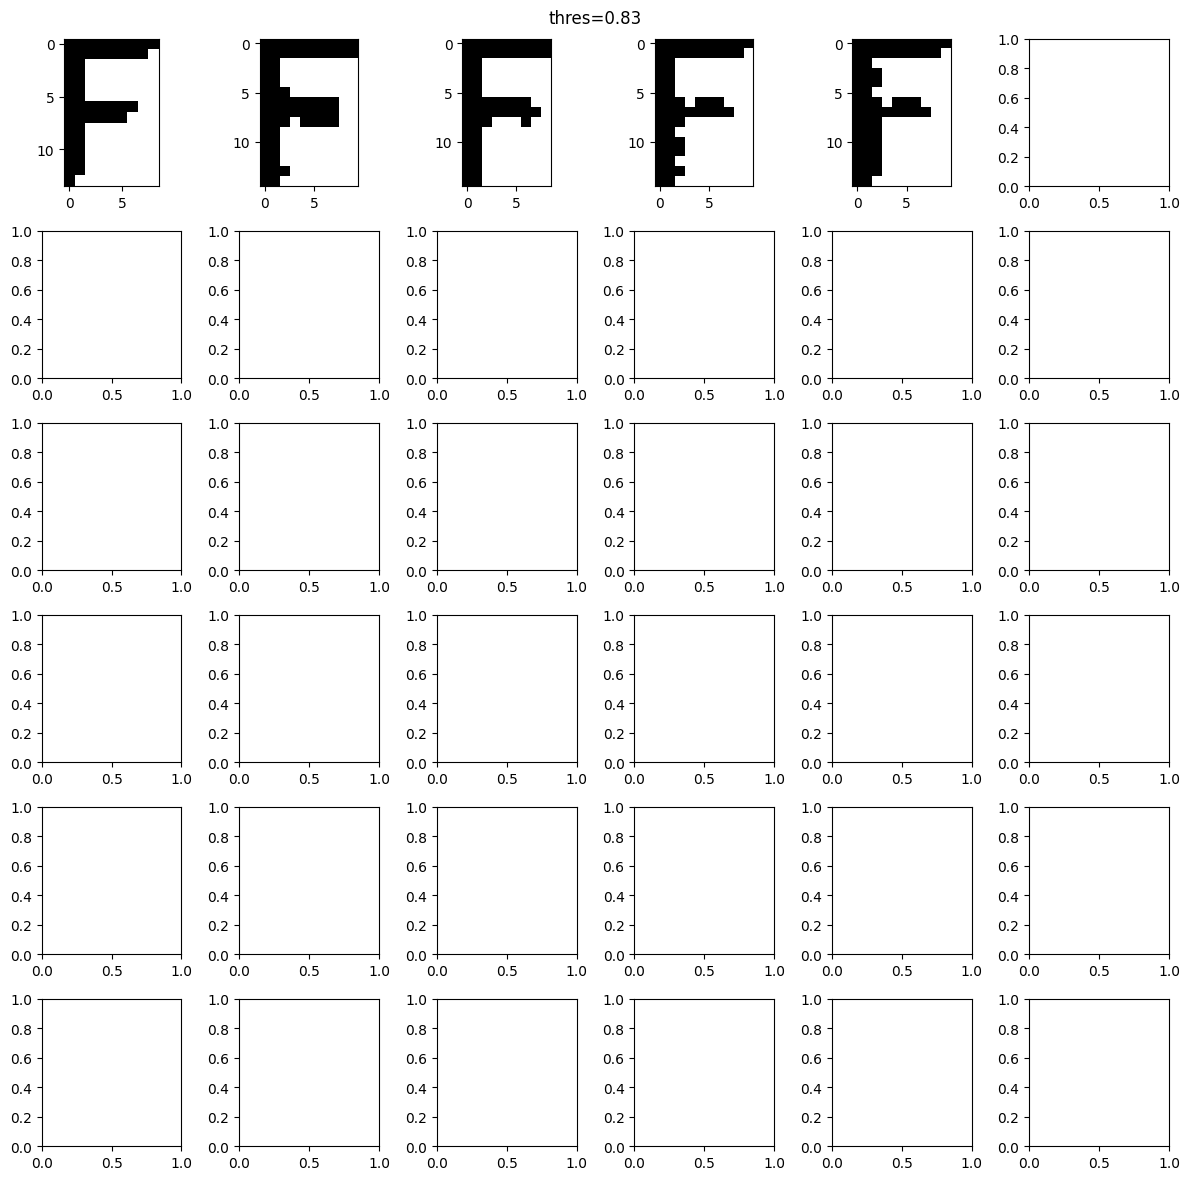

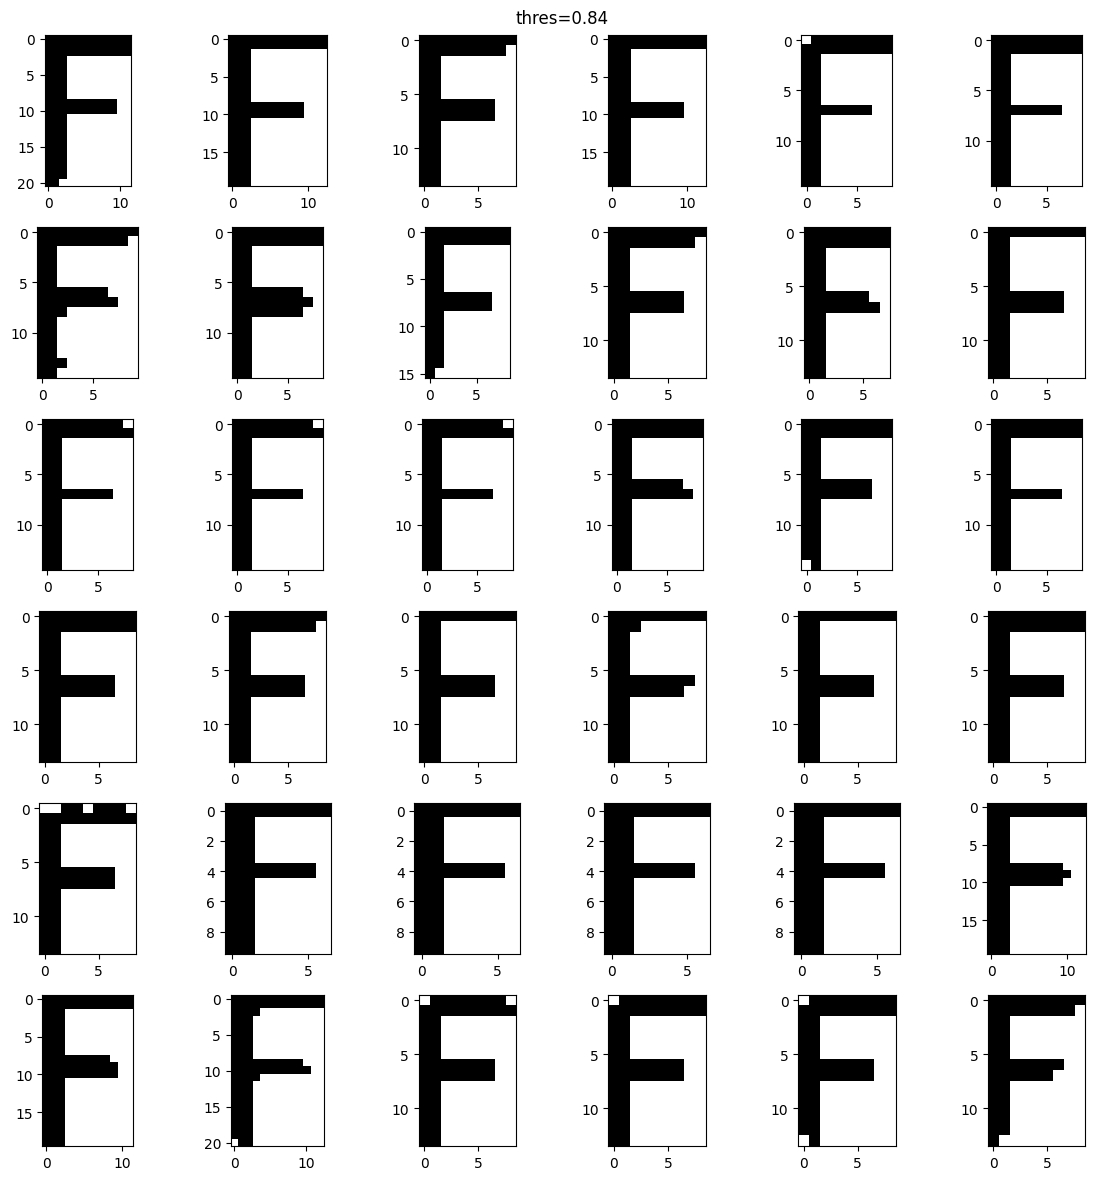

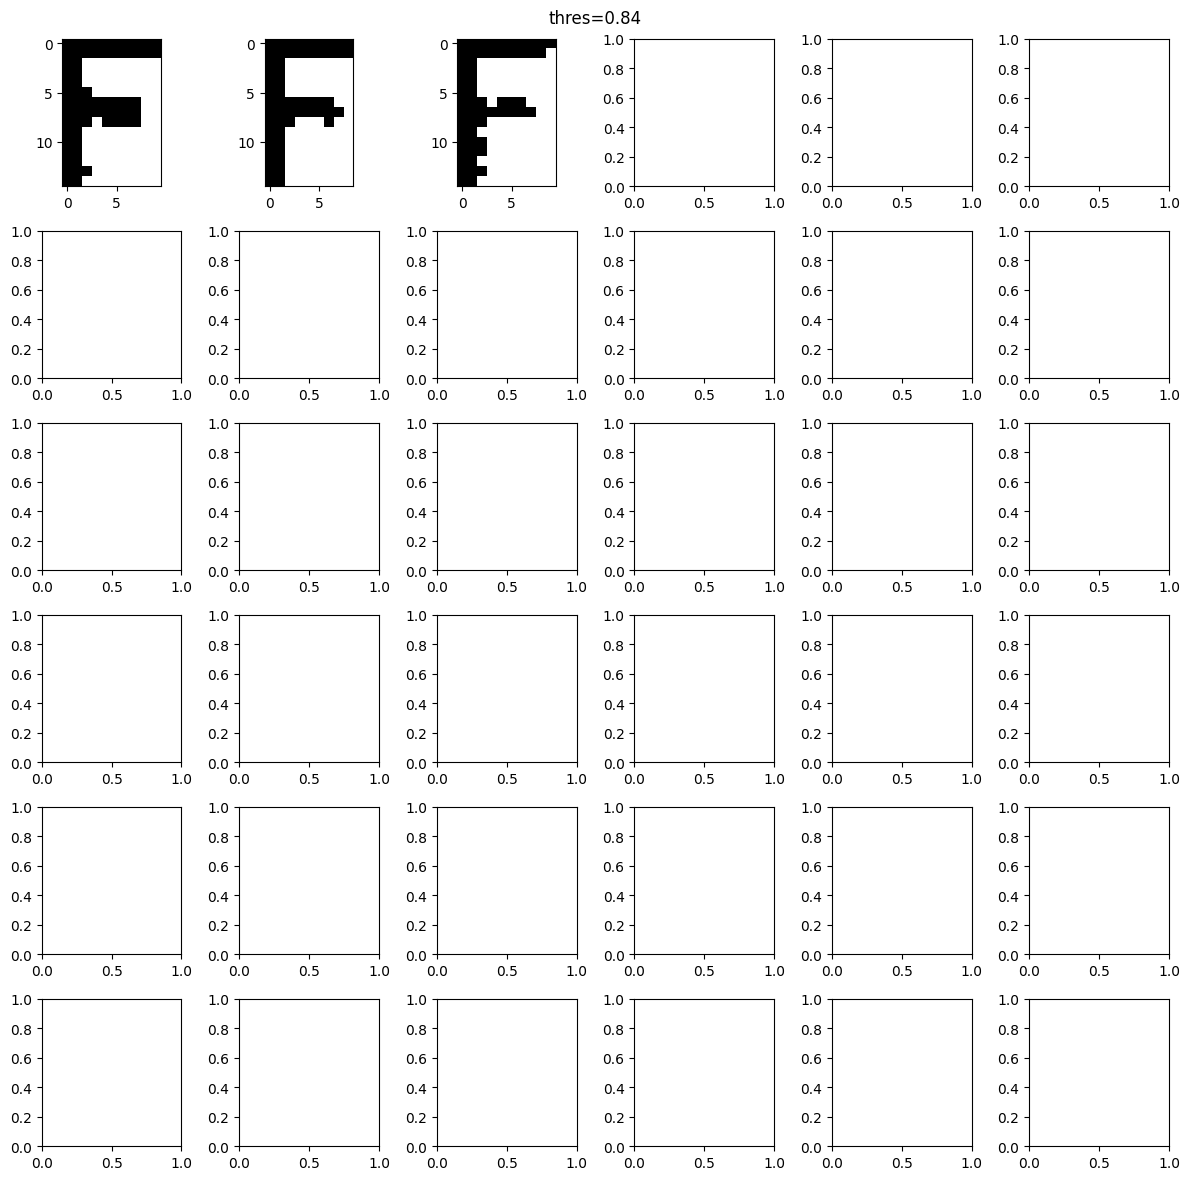

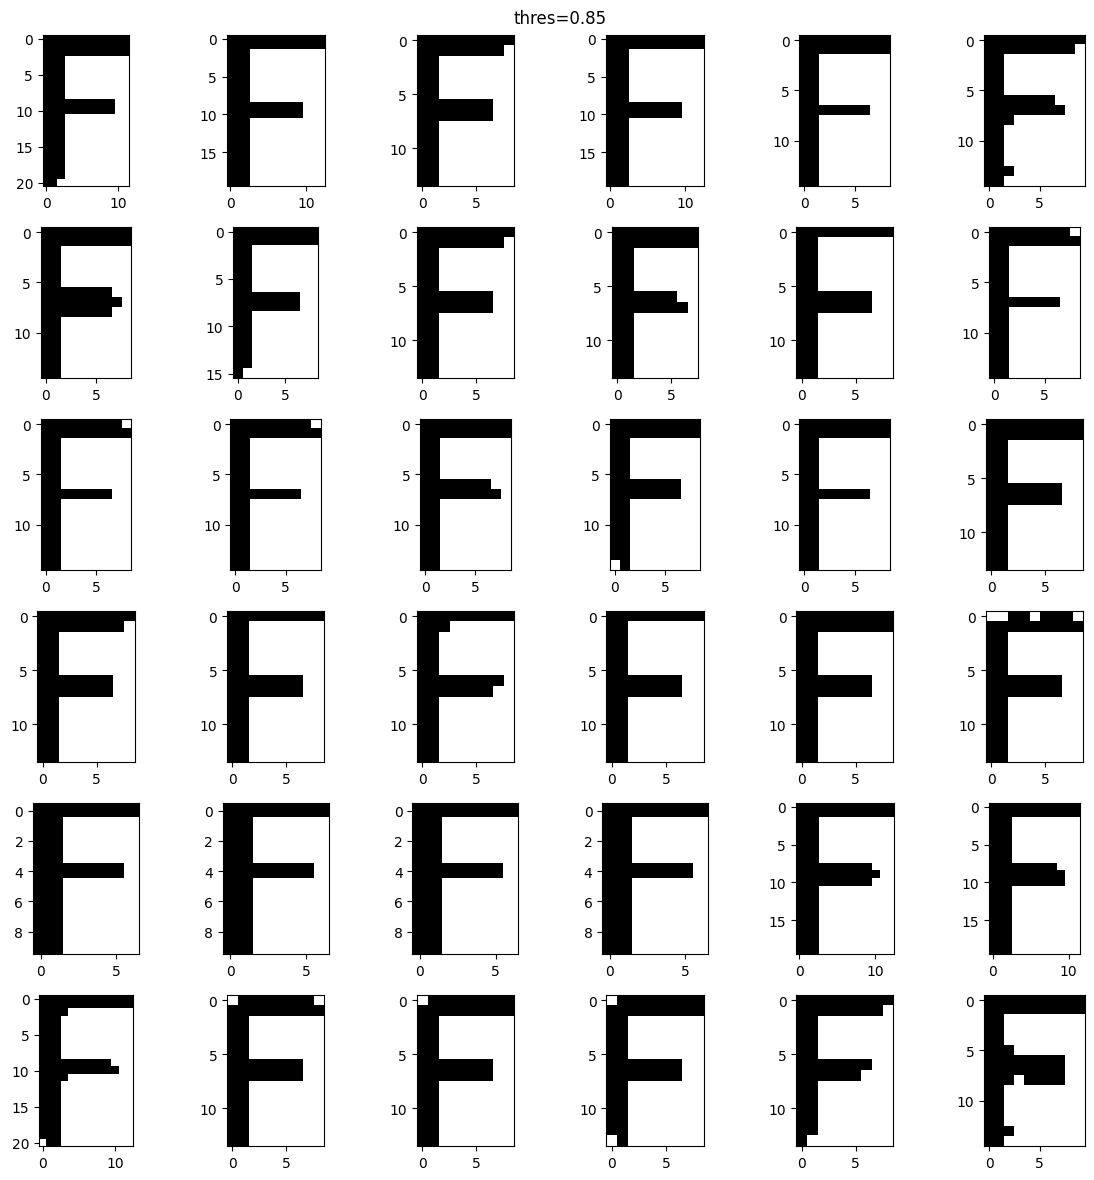

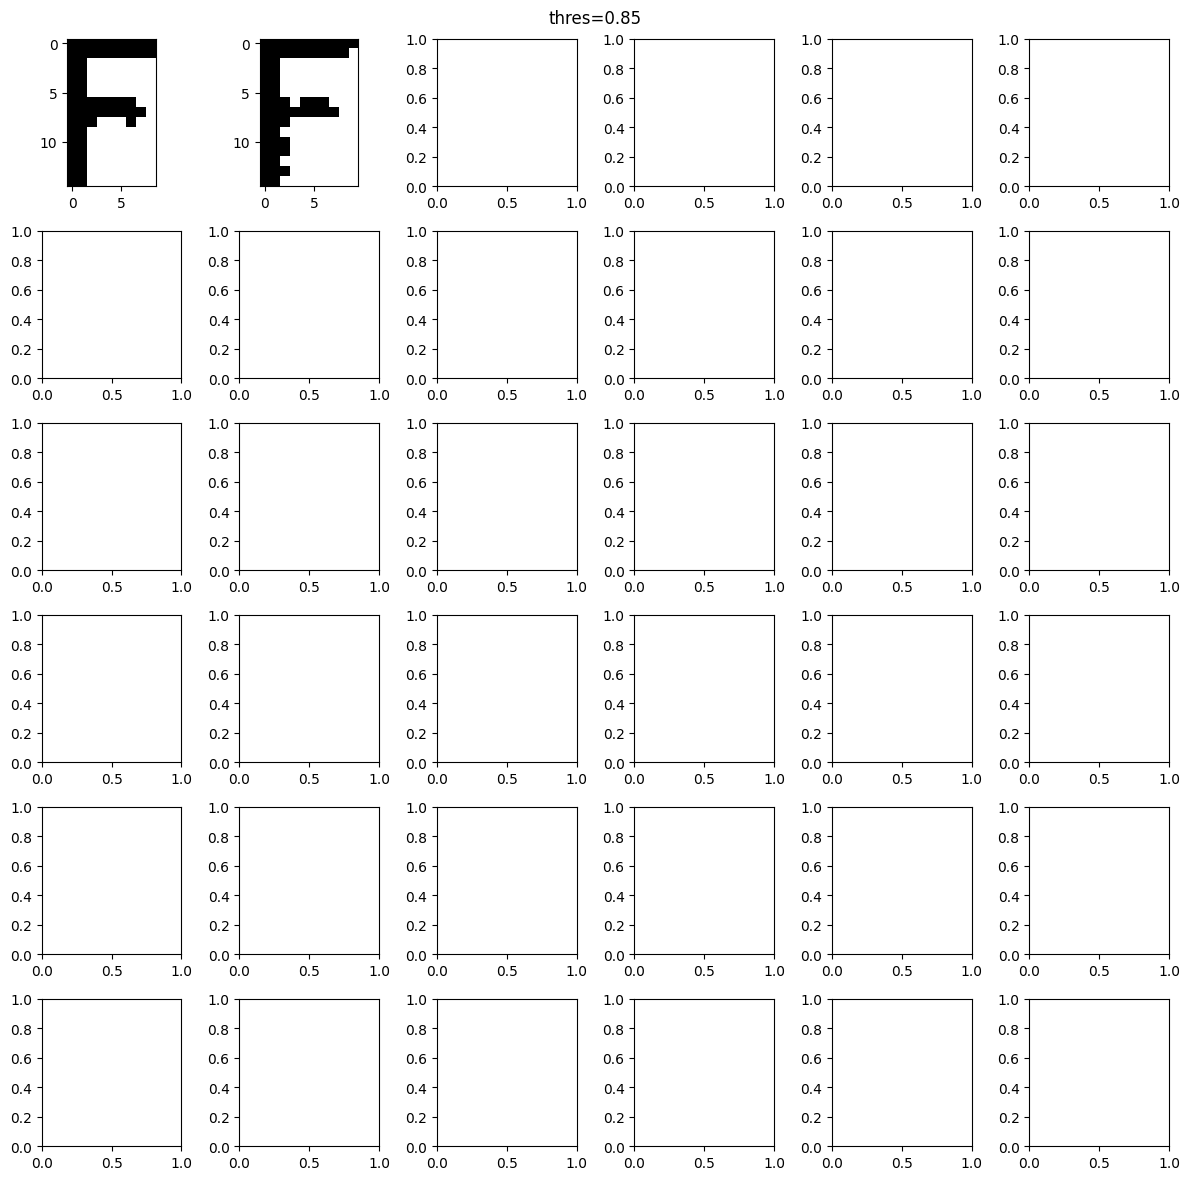

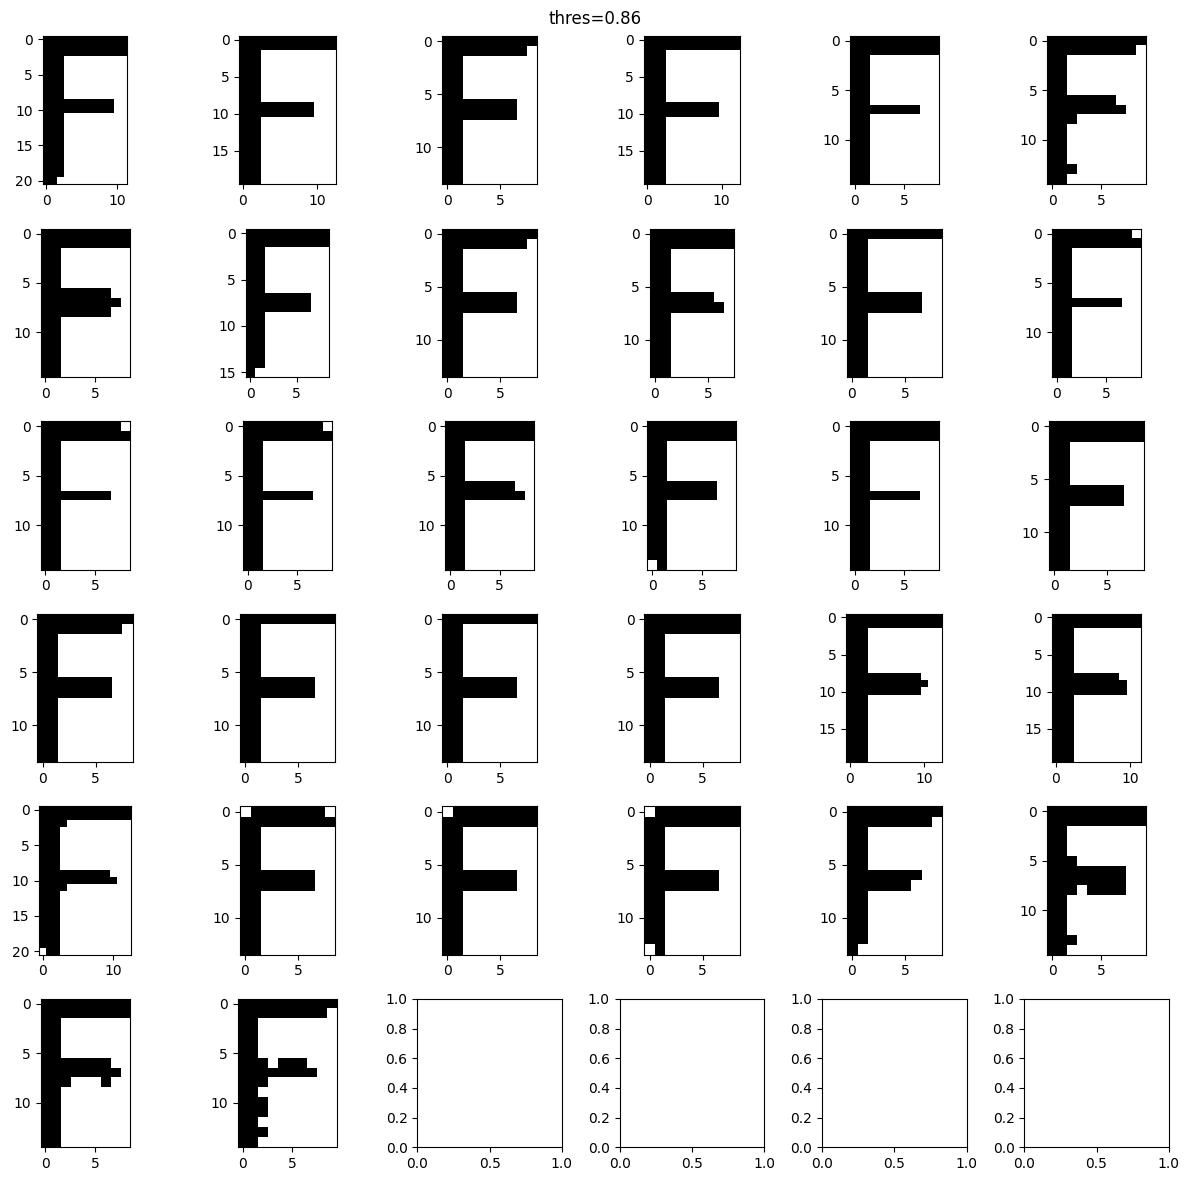

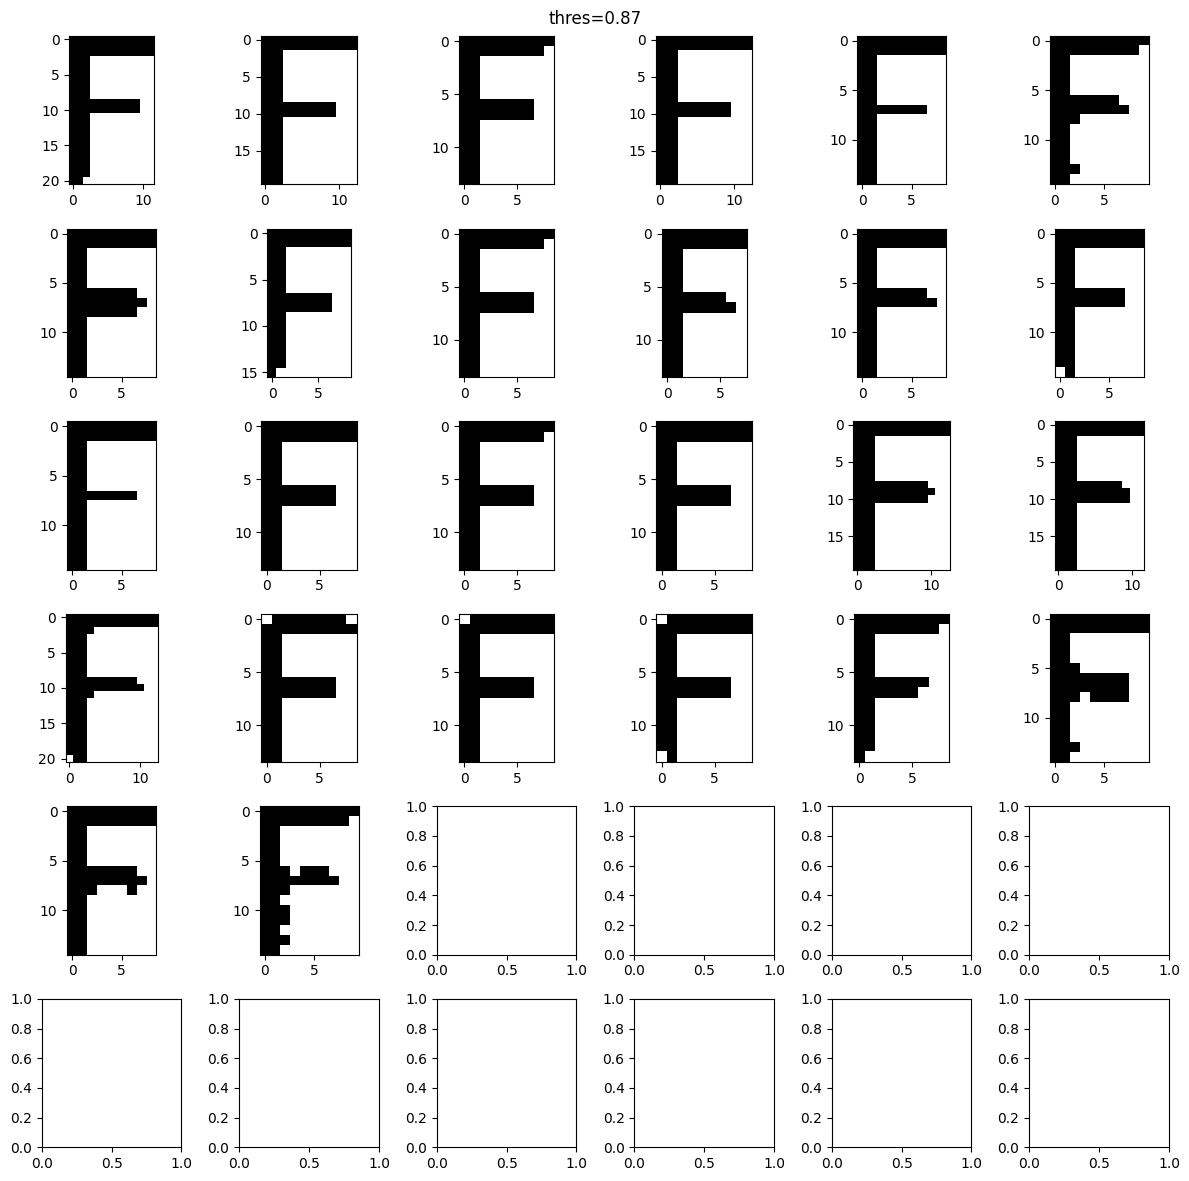

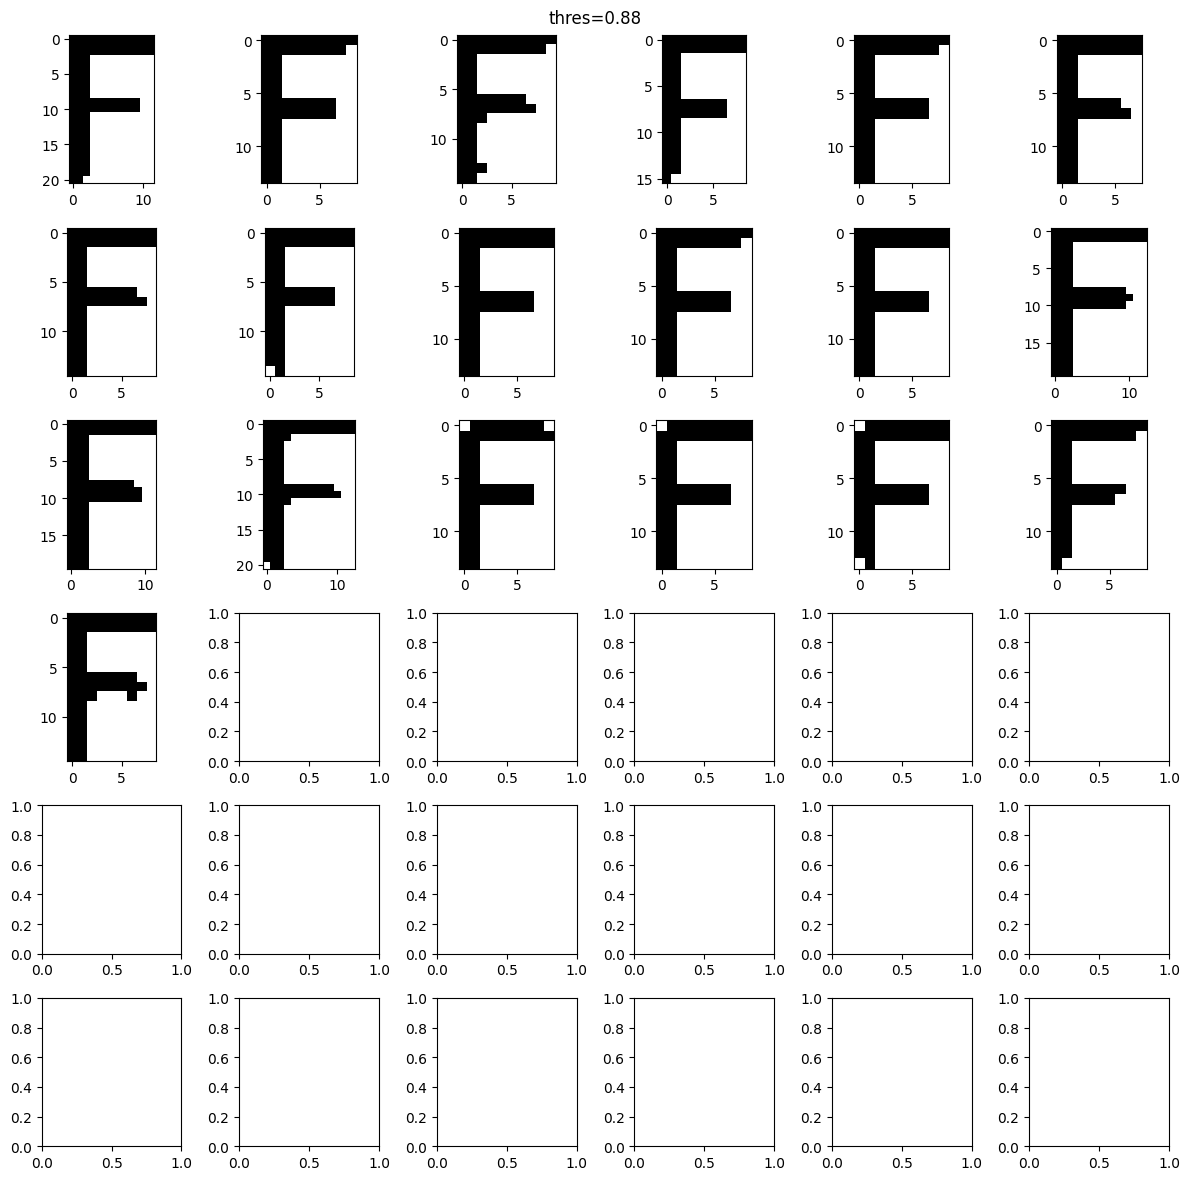

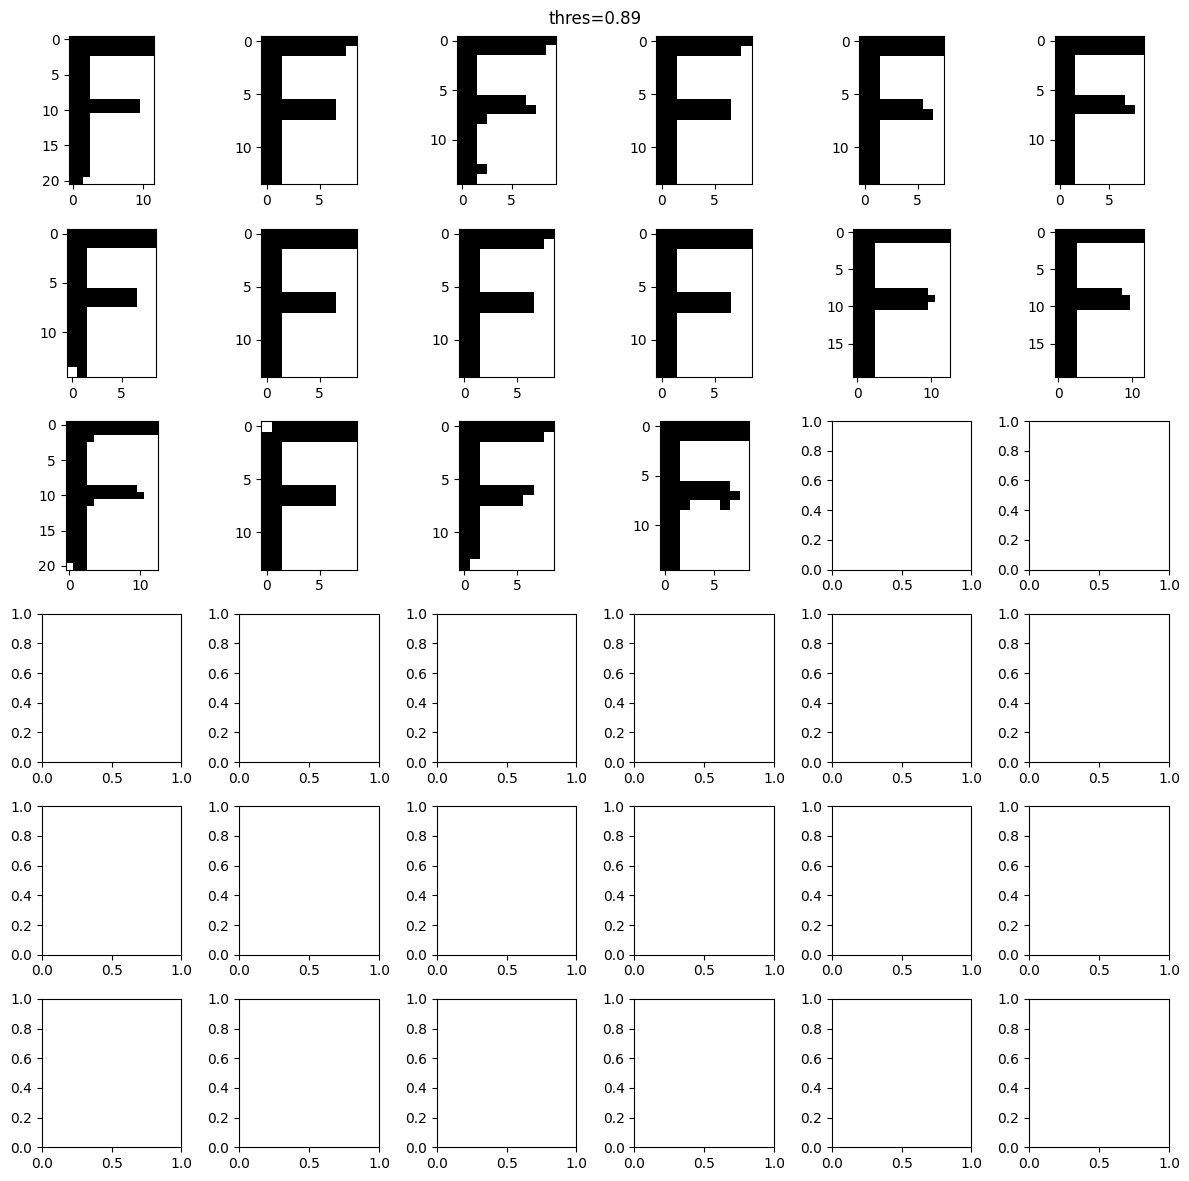

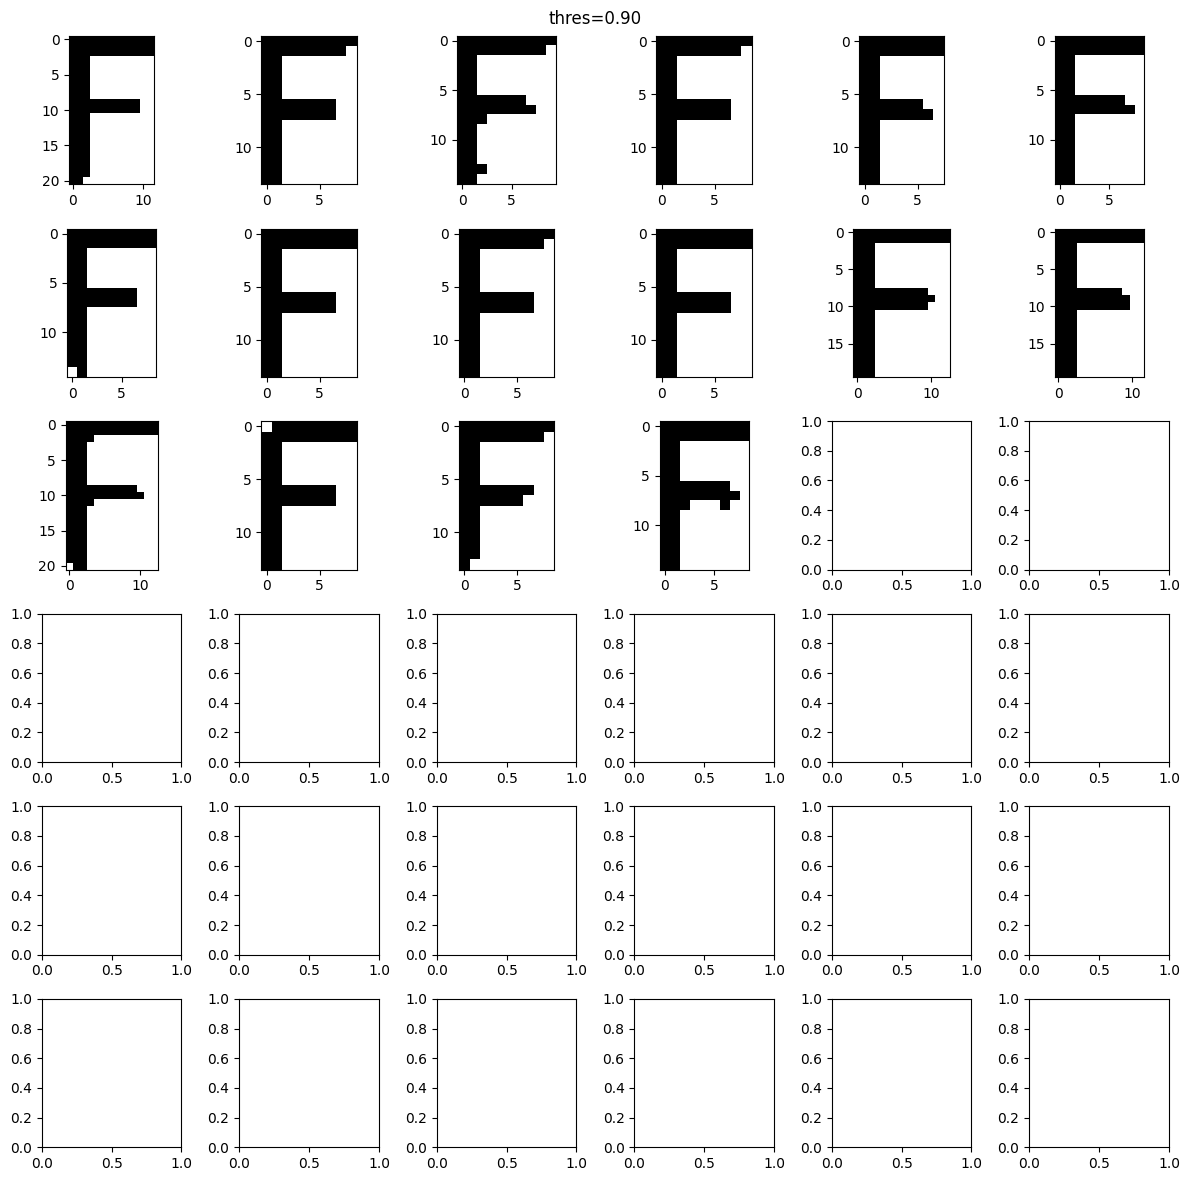

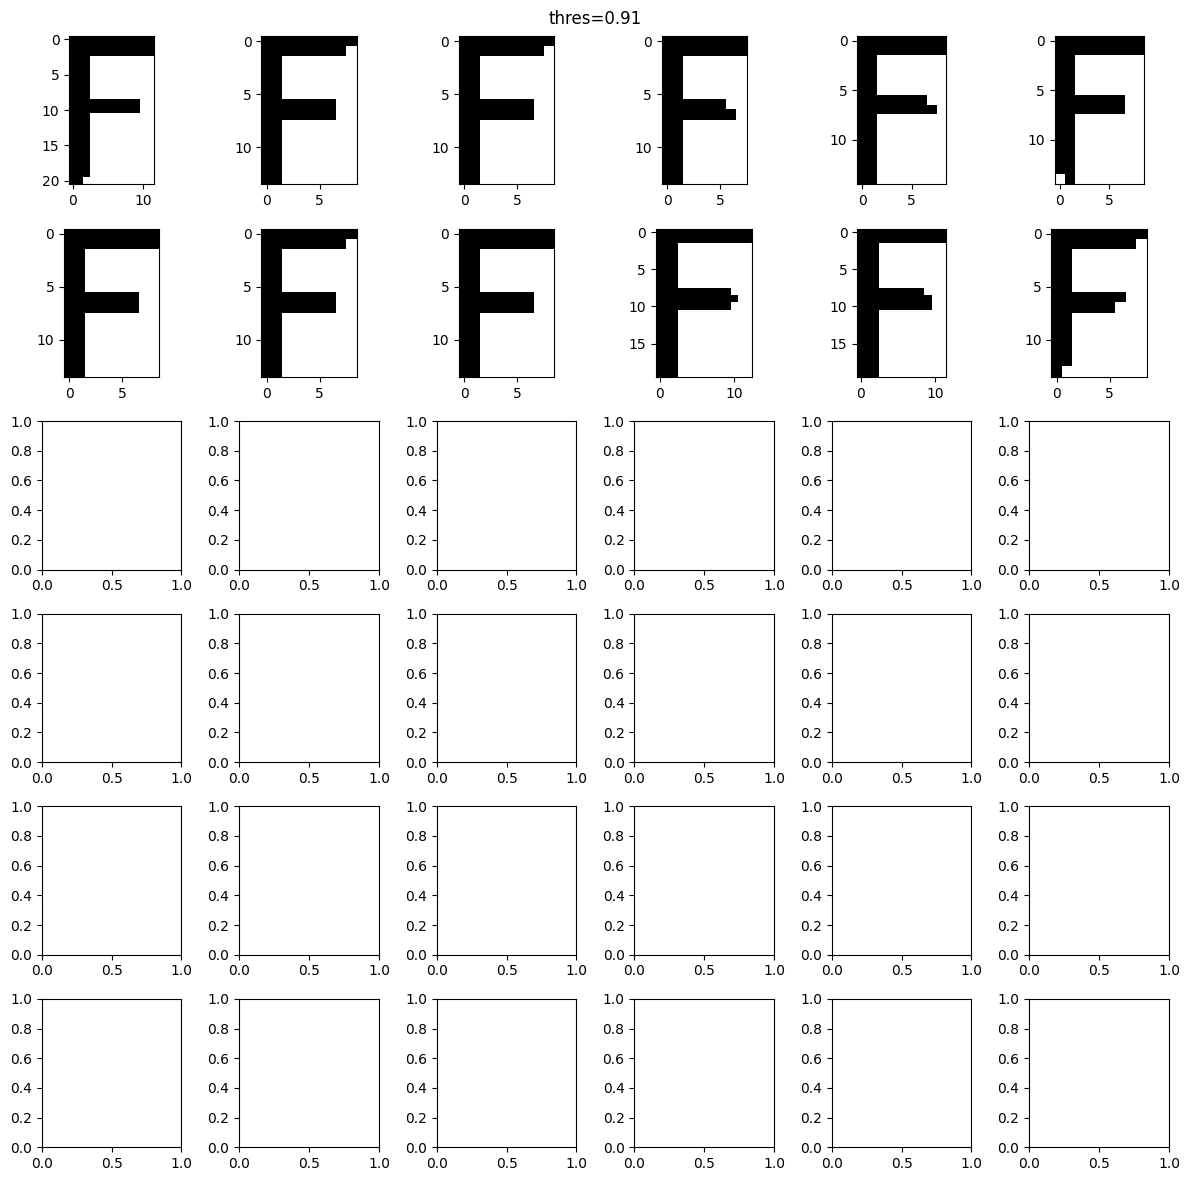

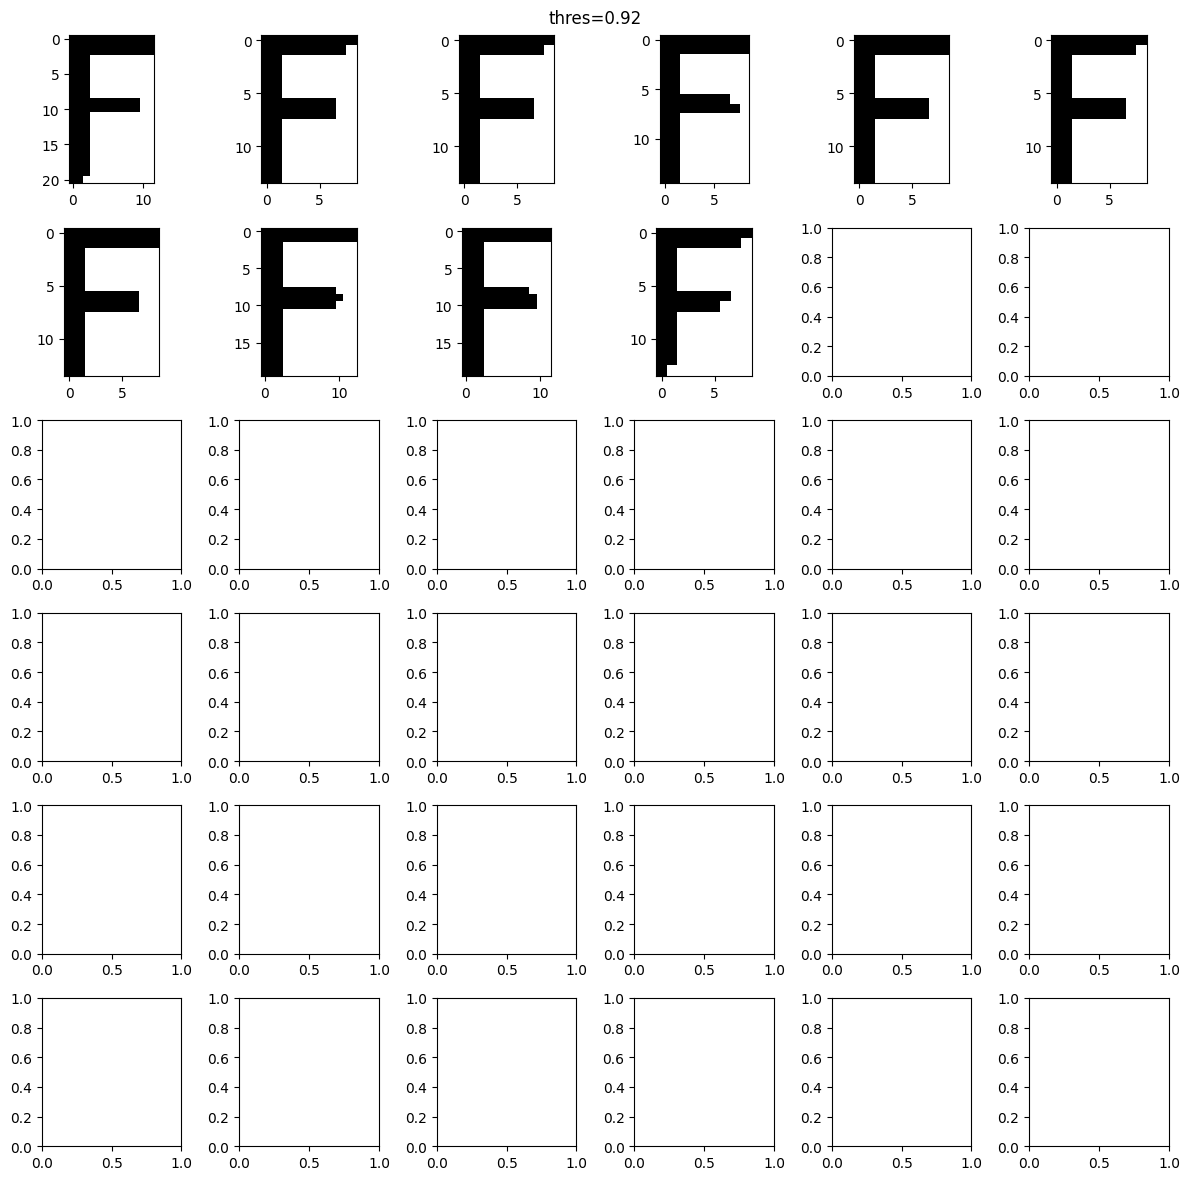

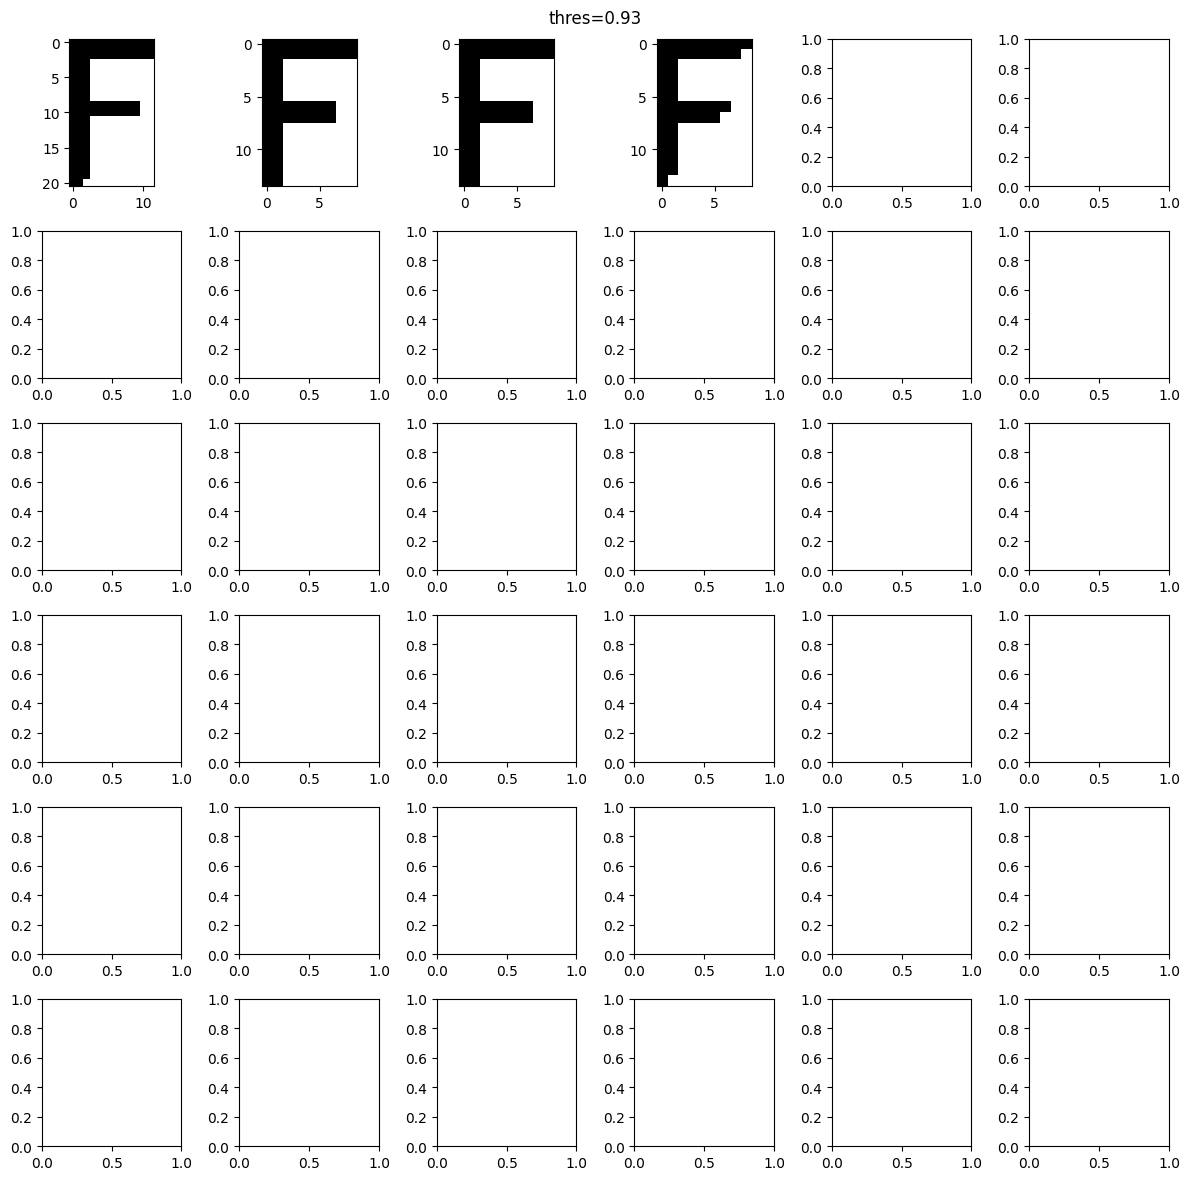

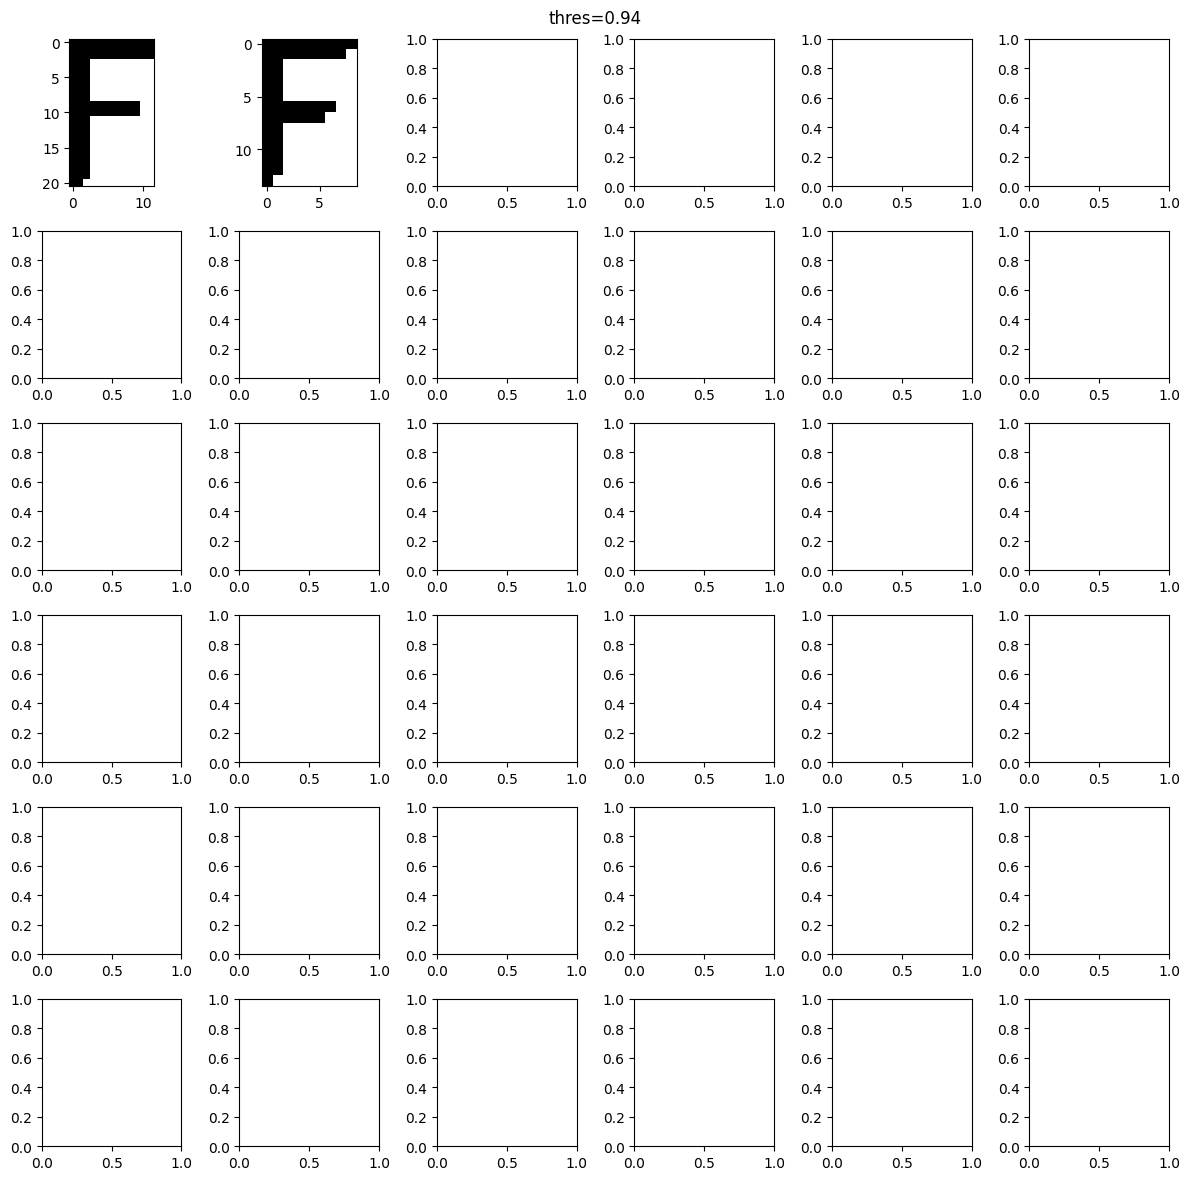

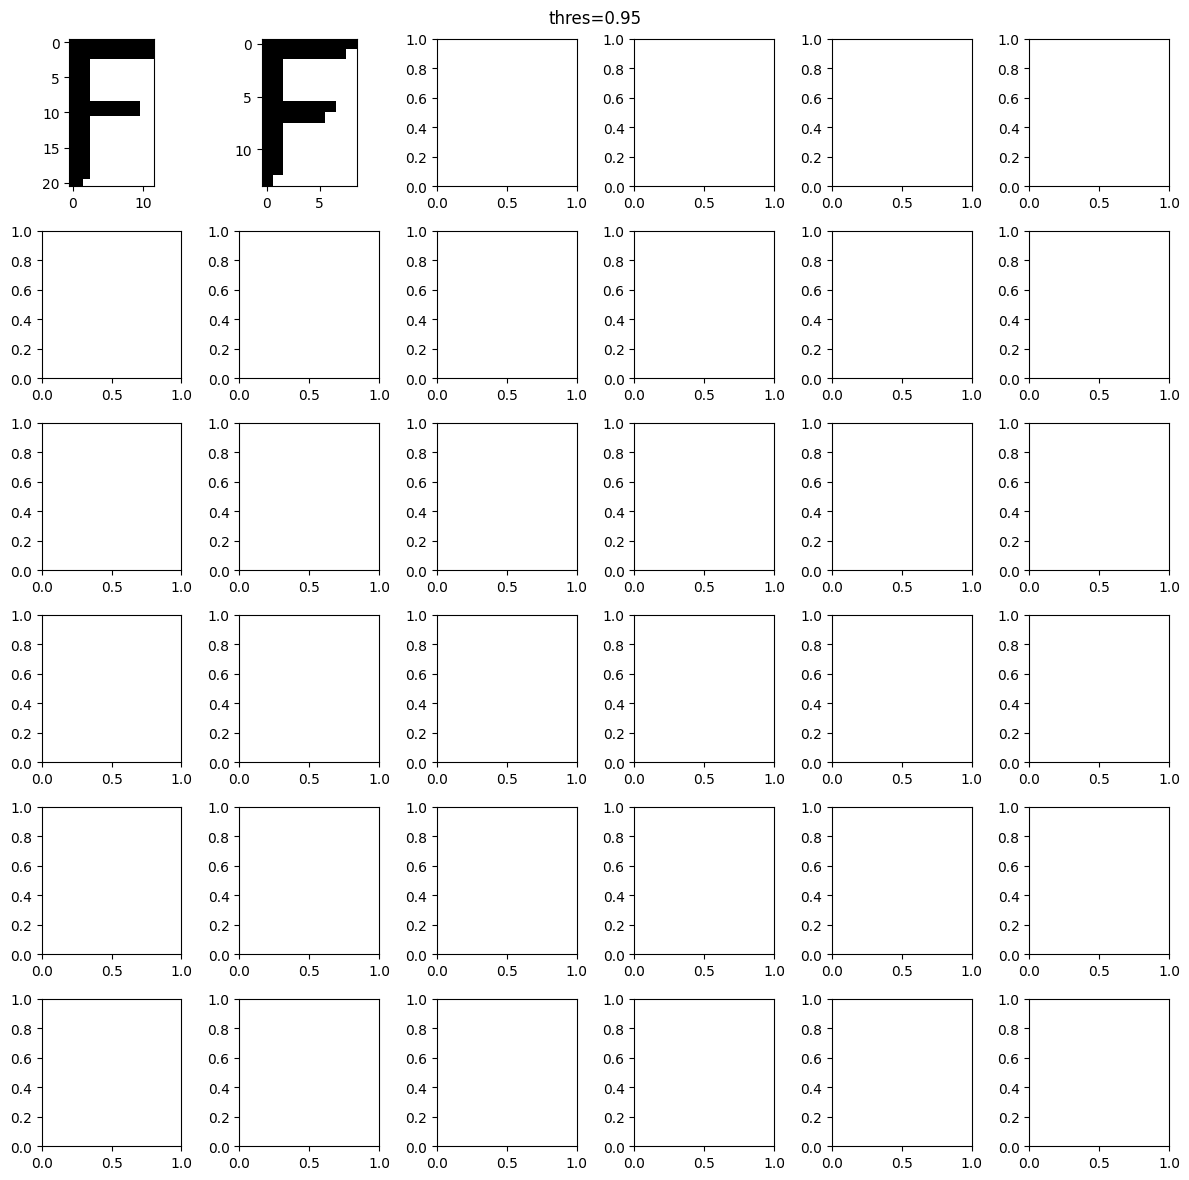

In [14]:
for thres in np.linspace(0.75, 0.95, 21):
    for i, idx in enumerate(np.arange(len(components))[similarities > thres]):
        if i % 36 == 0:
            fig, axs = plt.subplots(6, 6, figsize=(12, 12))
        fig.suptitle(f"{thres=:.2f}")
        j = i % 36
        axs[j // 6, j % 6].imshow(components[idx], cmap="gray_r")
        fig.tight_layout()

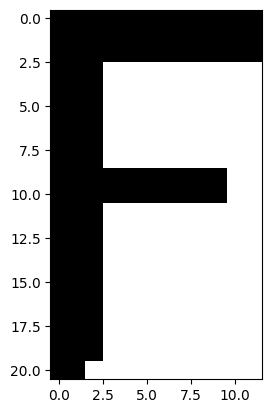

In [6]:
plt.imshow(components[156], cmap="gray_r")

In [7]:
ref

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [8]:
components[156]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)